# Телекоммуникации


## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Цель исследования

Построении модели предсказания, которая будет определять, останется ли пользователь клиентом компании или уйдет. Необходимо достичь значение  метрики   ROC-AUC  не ниже 0.85.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
pip install -U scikit-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report


RANDOM_STATE = 30723

### Знакомство с данными.

In [3]:
try:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv')

try:
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
except:
    df_personal = pd.read_csv('/datasets/personal_new.csv')

try:
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
except:
    df_internet = pd.read_csv('/datasets/internet_new.csv')

try:
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')
except:
    df_phone = pd.read_csv('/datasets/phone_new.csv')

In [4]:
def report(data):
    display (data.sample(5))
    display (data.info())
    print ('Размерность:', data.shape)
    display ('Количество пропущенных значений:', data.isna().sum())
    print ('Количество  дубликатов строк:', data.duplicated().sum())
    print ('Количество  дубликатов ID:', data['customerID'].duplicated().sum())

In [5]:
report(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5877,6777-TGHTM,2015-05-01,2018-02-01,One year,Yes,Credit card (automatic),106.95,3529.35
684,8040-MNRTF,2020-01-01,No,Month-to-month,No,Mailed check,71.10,71.1
5203,0734-OXWBT,2019-11-01,No,Month-to-month,No,Mailed check,70.70,212.1
1524,1656-DRSMG,2014-11-01,No,Month-to-month,Yes,Credit card (automatic),109.85,7612.6
1678,1060-ENTOF,2014-07-01,2018-09-01,One year,Yes,Credit card (automatic),105.40,5270.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Размерность: (7043, 8)


'Количество пропущенных значений:'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Количество  дубликатов строк: 0
Количество  дубликатов ID: 0


#### В файле contract_new.csv представлены данные о договорах с клиентами. Датафрейм содержит 7043 строки и 8 столбцов. Пропуски в данных отсутсвуют. Дубликатов строк не обнаружено. Дубликаты в колонке customerID  (уникальный идентификатор клиента) отсутсвуют. Колонка общие расходы (TotalCharges) имеет неверный тип данных, необходимо изменить тип данных  на  float64. Для дальнейших исследований необходимо изменить тип данных столбцов  начала (BeginDate) и конца действия договора (EndDate) на тип данных date.

In [6]:
report(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
6695,6253-GNHWH,Female,0,Yes,Yes
3535,3612-YUNGG,Male,0,Yes,Yes
502,3957-HHLMR,Female,0,Yes,Yes
1516,6198-RTPMF,Female,0,Yes,No
5954,7395-XWZOY,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Размерность: (7043, 5)


'Количество пропущенных значений:'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество  дубликатов строк: 0
Количество  дубликатов ID: 0


#### В файле personal_new.csv представлены персональные данные клиента. Датафрейм содержит 7043 строки и 5 столбцов. Пропуски в данных отсутсвуют. Дубликатов строк не обнаружено. Дубликаты в колонке customerID  (уникальный идентификатор клиента) отсутсвуют. Колонка  наличие пенсионного статуса (SeniorCitizen) - это  категориальный признак, необходимо изменить тип данных  на  object.

In [7]:
report(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1186,6543-JXSOO,DSL,Yes,Yes,No,Yes,No,No
4287,4277-UDIEF,DSL,Yes,No,No,Yes,Yes,Yes
3303,3519-ZKXGG,Fiber optic,No,No,No,No,No,No
2349,7613-LLQFO,Fiber optic,No,No,No,No,Yes,No
319,3597-MVHJT,Fiber optic,No,No,No,No,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Размерность: (5517, 8)


'Количество пропущенных значений:'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Количество  дубликатов строк: 0
Количество  дубликатов ID: 0


#### В файле internet_new.csv  содержится информация об интернет-услугах предоставляемых клиенту. Датафрейм содержит 5517 строки и 8 столбцов. Пропуски в данных отсутсвуют. Дубликатов строк не обнаружено. Дубликаты в колонке customerID (уникальный идентификатор клиента) отсутсвуют.

In [8]:
report(df_phone)

,customerID,MultipleLines
2870,3030-YZADT,No
392,5628-RKIFK,Yes
2648,7765-LWVVH,Yes
2911,6972-SNKKW,No
276,7277-OZCGZ,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Размерность: (6361, 2)


'Количество пропущенных значений:'

customerID       0
MultipleLines    0
dtype: int64

Количество  дубликатов строк: 0
Количество  дубликатов ID: 0


#### В файле phone_new.csv содержится информация об услугах телефонии предоставляемых клиенту. Датафрейм содержит 6361 строки и 2 столбца. Пропуски в данных отсутсвуют. Дубликатов строк не обнаружено. Дубликаты в колонке customerID (уникальный идентификатор клиента) отсутсвуют.

### Подготовка данных.

#### Изменим тип данных колонки TotalCharges датафрейма df_contract  на числовой тип.

In [9]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors ='coerce')
display (df_contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


None

Заметим, что при преобразовании типов  данных в колонке TotalCharges появились пропущенные  значения. Посмотрим на данные содержащие эти пропущенные значения.

In [10]:
df_contract[df_contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Очевидно, что это новые клиенты, подписавшие договор 01.02.2020 (на момент выгрузки данных) и не совершившие ни одного платежа.
Заполним  пропущенные значения в колонке TotalCharges  нулями.

In [11]:
df_contract['TotalCharges'].fillna(0, inplace=True)

#### Добавим в датафрейм df_contract новую колонку target с целевым признаком.
Значение "No" в столбце EndDate означает, что клиент продолжает пользоваться услугами компании и целевой признак равен 0. Если существует дата окончания договора, следовательно клиент отказался от услуг компании и целевой признак равен 1.

In [12]:
df_contract['target'] = df_contract['EndDate'].apply(lambda i: 1 if i != 'No' else 0)
display (df_contract.sample(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
3745,2645-QTLMB,2019-04-01,No,Month-to-month,Yes,Electronic check,94.25,1008.48,0
6788,1760-CAZHT,2018-01-01,No,Month-to-month,No,Mailed check,20.80,540.80,0
4831,4654-GGUII,2018-08-01,No,One year,Yes,Mailed check,40.20,723.60,0
6959,1024-KPRBB,2016-12-01,No,One year,Yes,Mailed check,89.10,3385.80,0
1494,2667-WYLWJ,2019-02-01,2019-12-01,One year,Yes,Mailed check,19.75,197.50,1


#### Изменим тип данных столбцов дата заключения договора (BeginDate) и дата расторжения договора (EndDate ) на тип данных date.
Так как информация о договорах актуальна на 01.02.2020, то для клиентов продолжающих пользоваться услугами компании (значение "No" в столбце EndDate) используем в качестве даты окончания договора дату 01.02.2020.

In [13]:
df_contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [14]:
df_contract.loc[(df_contract['EndDate'] == 'No'),'EndDate'] = '2020-02-01'

In [15]:
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'],format= "%Y/%m/%d")
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'],format= "%Y/%m/%d")

In [16]:
print(df_contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB
None


#### Изменим  тип данных колонки SeniorCitizen датафрейма df_personal на object.

In [17]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].astype('object')

In [18]:
print(df_personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None


#### Добавим в  таблицу df_contract  новую колонку   interval со значениями сколько дней клиент пользовался  услугами компании.

In [19]:
df_contract['interval'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days
display (df_contract.sample(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,interval
706,7596-ZYWBB,2014-09-01,2020-02-01,Two year,Yes,Mailed check,59.60,4028.96,0,1979
5520,8034-RYTVV,2015-07-01,2020-02-01,One year,Yes,Credit card (automatic),84.25,4958.11,0,1676
2925,2931-XIQBR,2015-12-01,2020-02-01,One year,No,Mailed check,103.05,5152.50,0,1523
1265,1004-NOZNR,2015-06-01,2020-02-01,One year,No,Credit card (automatic),94.80,5308.80,0,1706
4567,2697-NQBPF,2017-04-01,2018-05-01,Month-to-month,Yes,Electronic check,105.35,1438.03,1,395


#### Объединеним таблиц.
Предосталенные данные имеют общий стобец customerID, по которому можно объединить все датафреймы.

In [20]:
df_full = df_contract \
    .merge(df_personal, how='left', on='customerID') \
    .merge(df_internet, how='left', on='customerID') \
    .merge(df_phone, how='left', on='customerID')

In [21]:
print(df_full. info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
 9   interval          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   object        
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

#### Заполним пропуски.
Итоговый датафрейм  содержит пропуски, пропуски в данных означают, что человек не пользуется данной услугой.

In [22]:
df_full['MultipleLines'].fillna('no_phone', inplace = True)
df_full.fillna('no_internet_service', inplace = True)

In [23]:
print(df_full. info())
display (df_full.sample(5))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
 9   interval          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   7043 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,interval,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4262,5485-WUYWF,2019-11-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),66.40,199.20,0,92,...,No,No,DSL,Yes,No,Yes,No,Yes,No,No
999,3234-VKACU,2019-12-01,2020-02-01,Month-to-month,No,Electronic check,70.30,140.60,0,62,...,No,No,DSL,No,No,No,Yes,Yes,Yes,No
6098,4700-UBQMV,2018-05-01,2020-02-01,One year,Yes,Bank transfer (automatic),75.90,1593.90,0,641,...,Yes,Yes,DSL,Yes,No,No,No,Yes,Yes,Yes
4269,9170-CCKOU,2018-07-01,2019-03-01,Month-to-month,No,Credit card (automatic),90.20,750.46,1,243,...,Yes,No,Fiber optic,Yes,Yes,Yes,No,No,No,Yes
2823,4884-LEVMQ,2016-11-01,2020-02-01,Two year,Yes,Bank transfer (automatic),20.45,821.48,0,1187,...,Yes,No,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,No


### План дальнейших шагов.

* #### Исследовательский анализ данных
  1. Изучим распределение значений для категориальных признаков.
  2. Изучим распределение значений и диаграммы размаха для количественных признаков.
  3. Изучим распределение категорильных признаков для оставшихся и ушедших клиентов.
  4. Изучим распределение количественных признаков для оставшихся и ушедших клиентов.
  5. Проверим корреляцию между количественными признаками, в случае мультиколлинеарности удалим один из признаков.
* #### Подготовка данных для моделей
  1. Удалим ненужные для обучения столбцы.
  1. Выделим фичи и целевую переменную target.
  3. Разделим данные на обучающую и тестовую выборки.
  4. Для кодирования  категориальных признаков  и масштабирования числовых признаков используем make_column_transformer.
* #### Обучение моделей
  1. Создадим и обучим различные модели на тестовой выборке: LogisticRegression, RandomForestClassifier, LGBMClassifier.
  2. Для подбора гиперпараметров используем  GridSearch + pipeline. Используем метрику ROC-AUC.
  3. Построим для каждой модели ROC- кривую.
* #### Тестирование лучшей модели.
  1. Рассчитаем значение ROC-AUC на тестовой выборке для лучшей модели. Построим ROC- кривую.
  2. Вычилим важность факторов для лучшей модели.
* #### Вывод


### Исследовательский анализ данных.

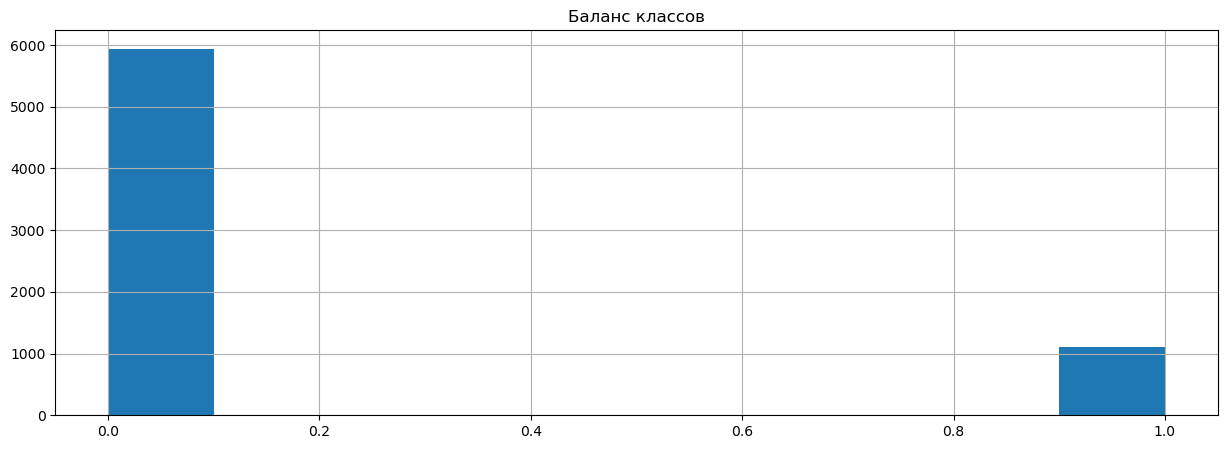

In [24]:
plt.figure(figsize=(15,5))
df_full['target'].hist()
plt.title('Баланс классов')
plt.show()

In [25]:
class_balance = df_full['target'].value_counts()
print(class_balance)

0    5942
1    1101
Name: target, dtype: int64


#### Мы наблюдаем, что 1101 клиент решил расторгнуть договор, в то время как 5942 клиента продолжают пользоваться услугами компании. Таким образом, 15,6% клиентов прекратили пользоваться услугами компании.

#### Построим гистограмму  колличества заключенных договоров

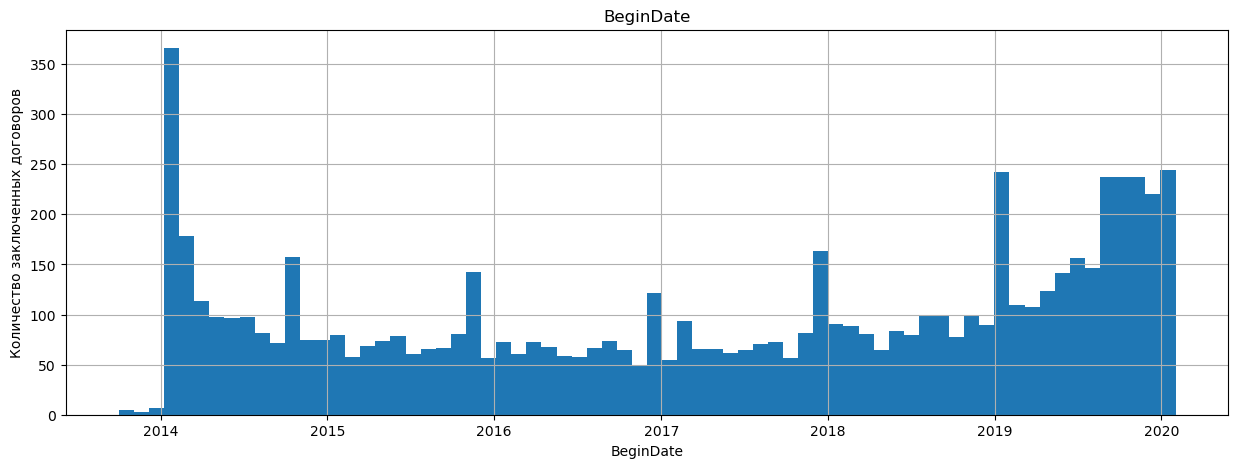

In [26]:
plt.figure(figsize=(15,5))
df_full['BeginDate'].hist(bins = 70)
plt.ylabel('Количество заключенных договоров')
plt.xlabel('BeginDate')
plt.title('BeginDate')
plt.show()

#### Данная диаграмма презентует информацию о количестве заключенных договоров, которые состоялись ежемесячно. Наблюдается тенденция к увеличению числа заключенных договоров начиная с 2018 года.

#### Построим гистограмму  колличества расторгнутых  договоров.

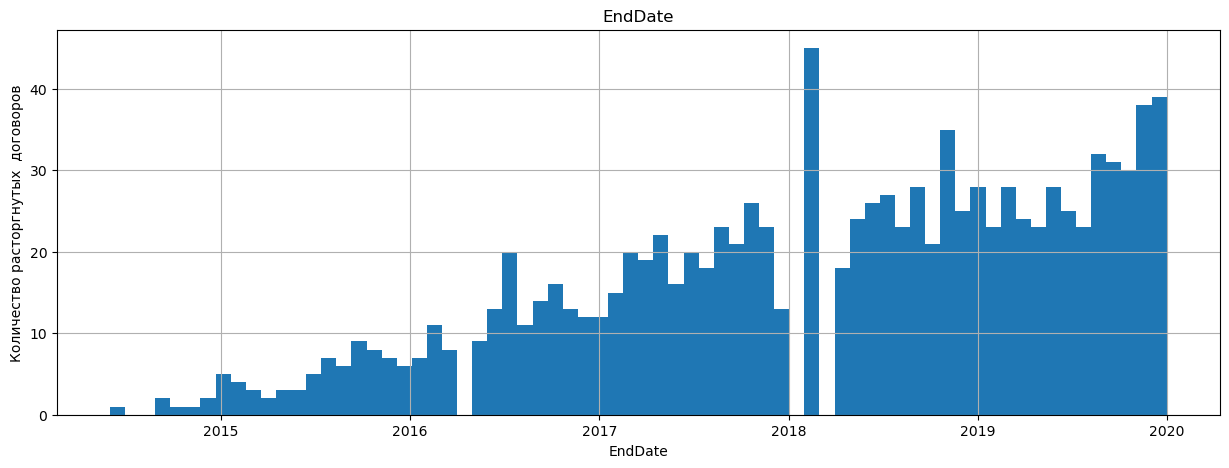

In [27]:
filtered_df = df_full[df_full['target'] == 1]
plt.figure(figsize=(15,5))
filtered_df['EndDate'].hist(bins =70)
plt.ylabel('Количество расторгнутых  договоров')
plt.xlabel('EndDate')
plt.title('EndDate')
plt.show()

#### Мы наблюдаем, что со  временем количество расторгнутых договоров растет.

#### Cоздадим гистограмму, которая покажет, как долго различные клиенты использовали услуги компании до расторжения договора.

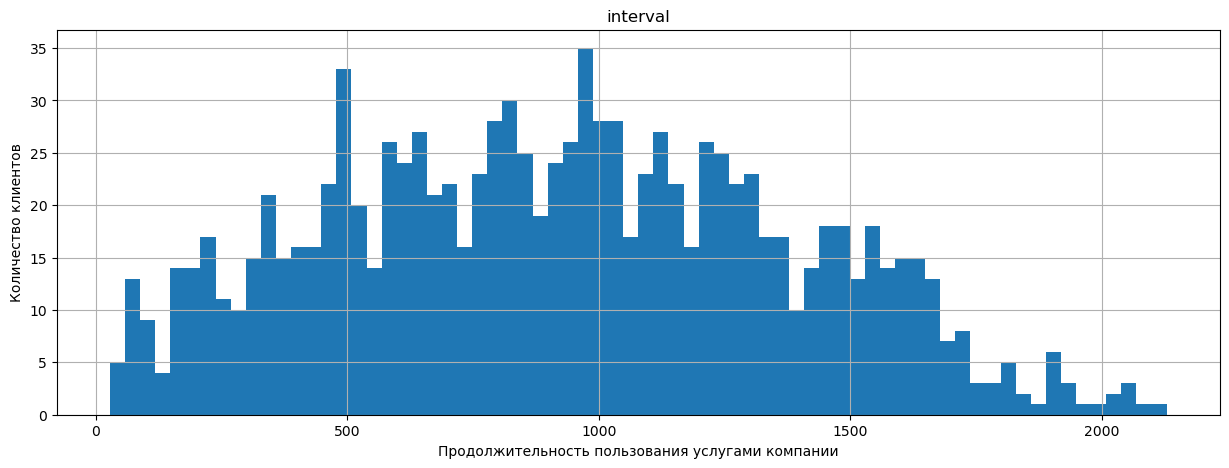

In [28]:
plt.figure(figsize=(15,5))
filtered_df['interval'].hist(bins =70)
plt.ylabel('Количество клиентов')
plt.xlabel('Продолжительность пользования услугами компании')
plt.title('interval')
plt.show()

#### В среднем, длительность использования услуг для клиентов, которые расторгли договор, составляет 1000 дней.

#### Посмотрим  количество действующих договоров на определенную дату.

         Дата  Действующие договоры
0  2013-10-31                     3
1  2013-11-30                     5
2  2013-12-31                     8
3  2014-01-31                    15
4  2014-02-28                   381
..        ...                   ...
71 2019-09-30                  5142
72 2019-10-31                  5348
73 2019-11-30                  5555
74 2019-12-31                  5737
75 2020-01-31                  5931

[76 rows x 2 columns]


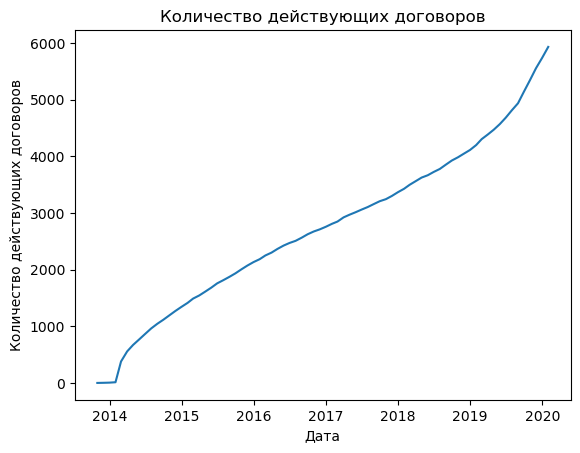

In [29]:
min_date = df_full['BeginDate'].min()
dates = pd.date_range(start=min_date, end='2020-02-01', freq='M')

active_contracts = []
for date in dates:
    count = ((date >= df_full['BeginDate']) & (date <= df_full['EndDate'])).sum()
    active_contracts.append(count)

# Создание DataFrame с количеством действующих договоров на каждую дату
result = pd.DataFrame({'Дата': dates, 'Действующие договоры': active_contracts})
print(result)

plt.plot(result['Дата'], result['Действующие договоры'])
plt.xlabel('Дата')
plt.ylabel('Количество действующих договоров')
plt.title('Количество действующих договоров')
plt.show()

#### Мы наблюдаем активное развитие компании, при этом 15,6% клиентов решили прекратить пользоваться услугами компании. В среднем, длительность использования  услуг для клиентов, которые расторгли договор, составляет 1000 дней.

#### Выберем категориальные признаки.

In [30]:
df_full['SeniorCitizen'] = df_full['SeniorCitizen'].astype('object')
categorical_columns = df_full.select_dtypes(include=['object']).columns.to_list()
categorical_columns.remove('customerID')
print(categorical_columns)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


#### Построим гистограммы для каждого категориального признака.

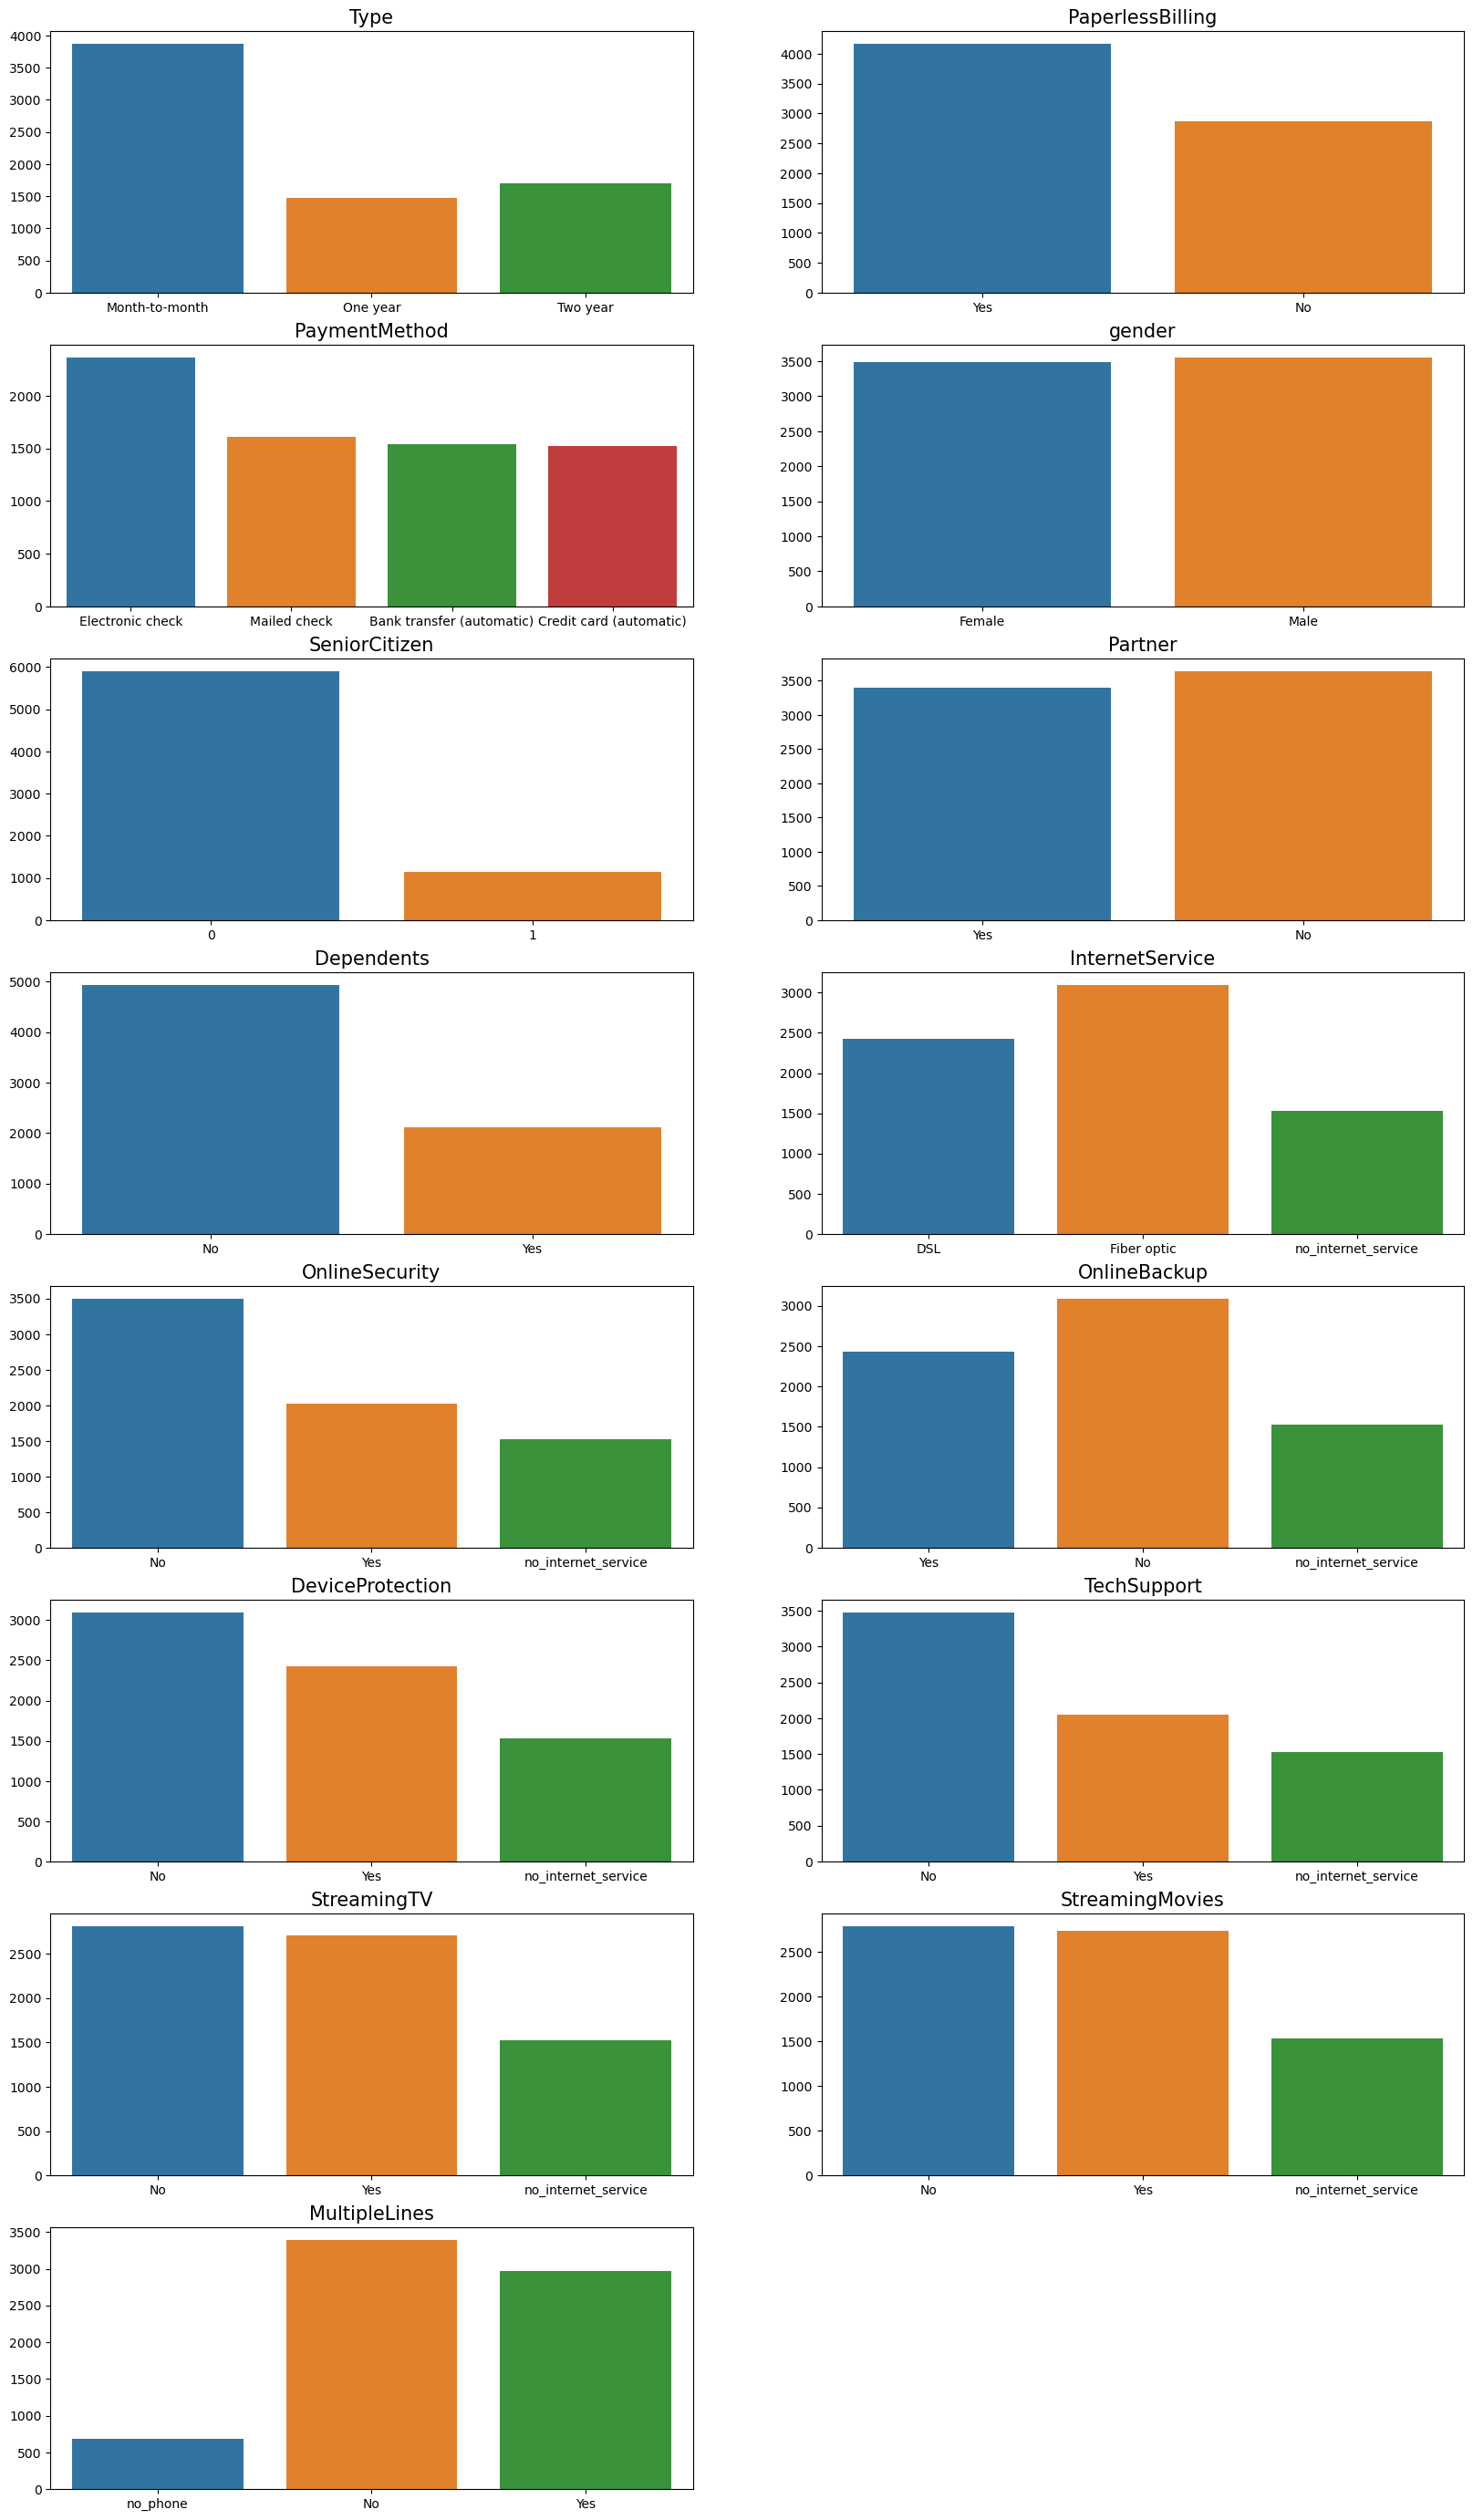

In [31]:
num_plots = len(categorical_columns)
num_columns = 2
num_rows = int(np.ceil(len(categorical_columns) / num_columns))
fig, axs = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20,35))

for i, column in enumerate(categorical_columns):
    row = i // num_columns
    col = i % num_columns
    sns.countplot(data=df_full, x=column, ax=axs[row, col])
    axs[row, col].set_title(column, fontsize=15)
    axs[row, col].set_xlabel(None)
    axs[row, col].set_ylabel(None)
if num_plots < num_rows * num_columns:
    for j in range(num_plots, num_rows * num_columns):
        fig.delaxes(axs.flatten()[j])

plt.show()

#### Большинство людей предпочитает оплачивать счета ежемесячно через электронный чек, получая счета в электронном виде. Оптоволокно является самым распространенным способом подключения. Гендерный состав клиентов компании практически равномерно распределен. Количество клиентов, не имеющих партнера, немного превышает количество клиентов, имеющих супруга или супругу. Около 15% клиентов компании находятся в пенсионном возрасте. Среди  клиентов наблюдается значительно меньшее количество клиентов, у которых есть иждивенцы. Около половины интернет-пользователей  использует услуги OnlineBackup, StreamingTV и StreamingMovies. Услуги OnlineSecurity, DeviceProtection, TechSupport  менее популярны среди пользователей.  MultipleLines используют менее половины клиентов.

#### Построим гистограммы для  цифровых признаков.

In [32]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'interval']

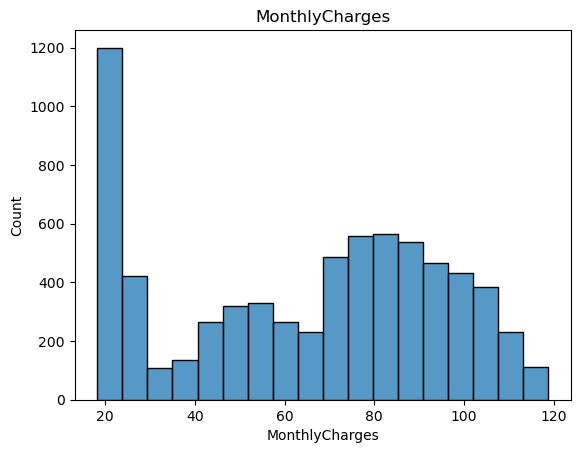

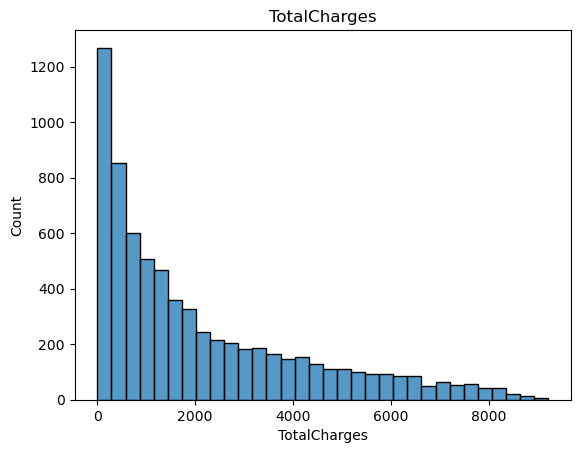

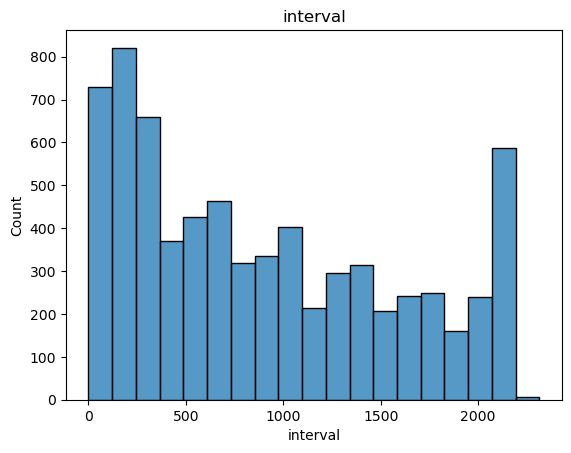

In [33]:
for column in numeric_columns:
        plt.figure()
        sns.histplot(df_full[column])
        plt.title(column)
        plt.show()

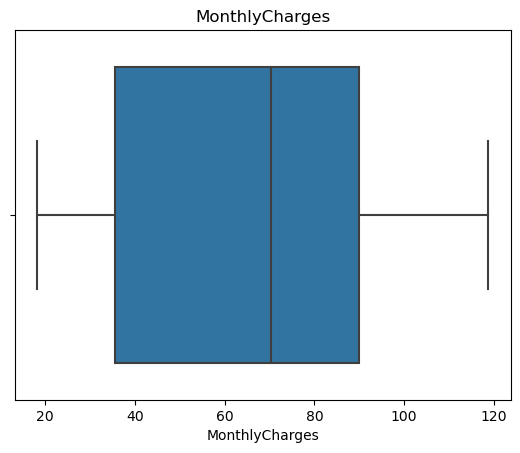

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

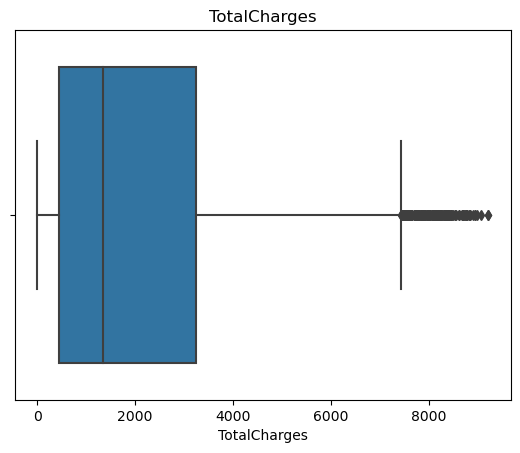

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

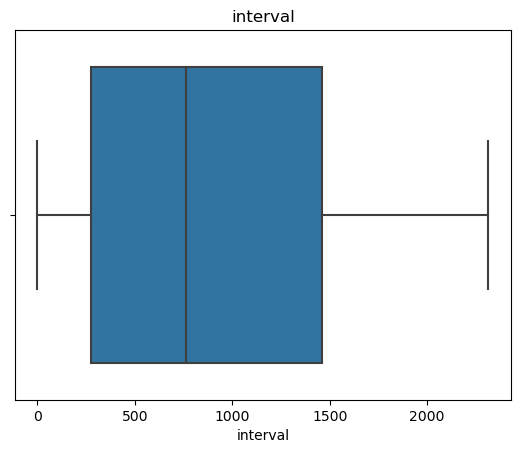

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: interval, dtype: float64

In [34]:
for column in numeric_columns:
        plt.figure()
        sns.boxplot(df_full[column])
        plt.title(column)
        plt.show()
        display(df_full[column].describe())

####  Гистограмма  MonthlyCharges  имеет два горба, показывает бимодальность, следовательно в  выборке есть несколько однородных выборок. Попробуем выделить фактор, который объяснит эту бимодальность. Отфильтруем клиентов со стоимостью ежемесячного платежа не более 25.

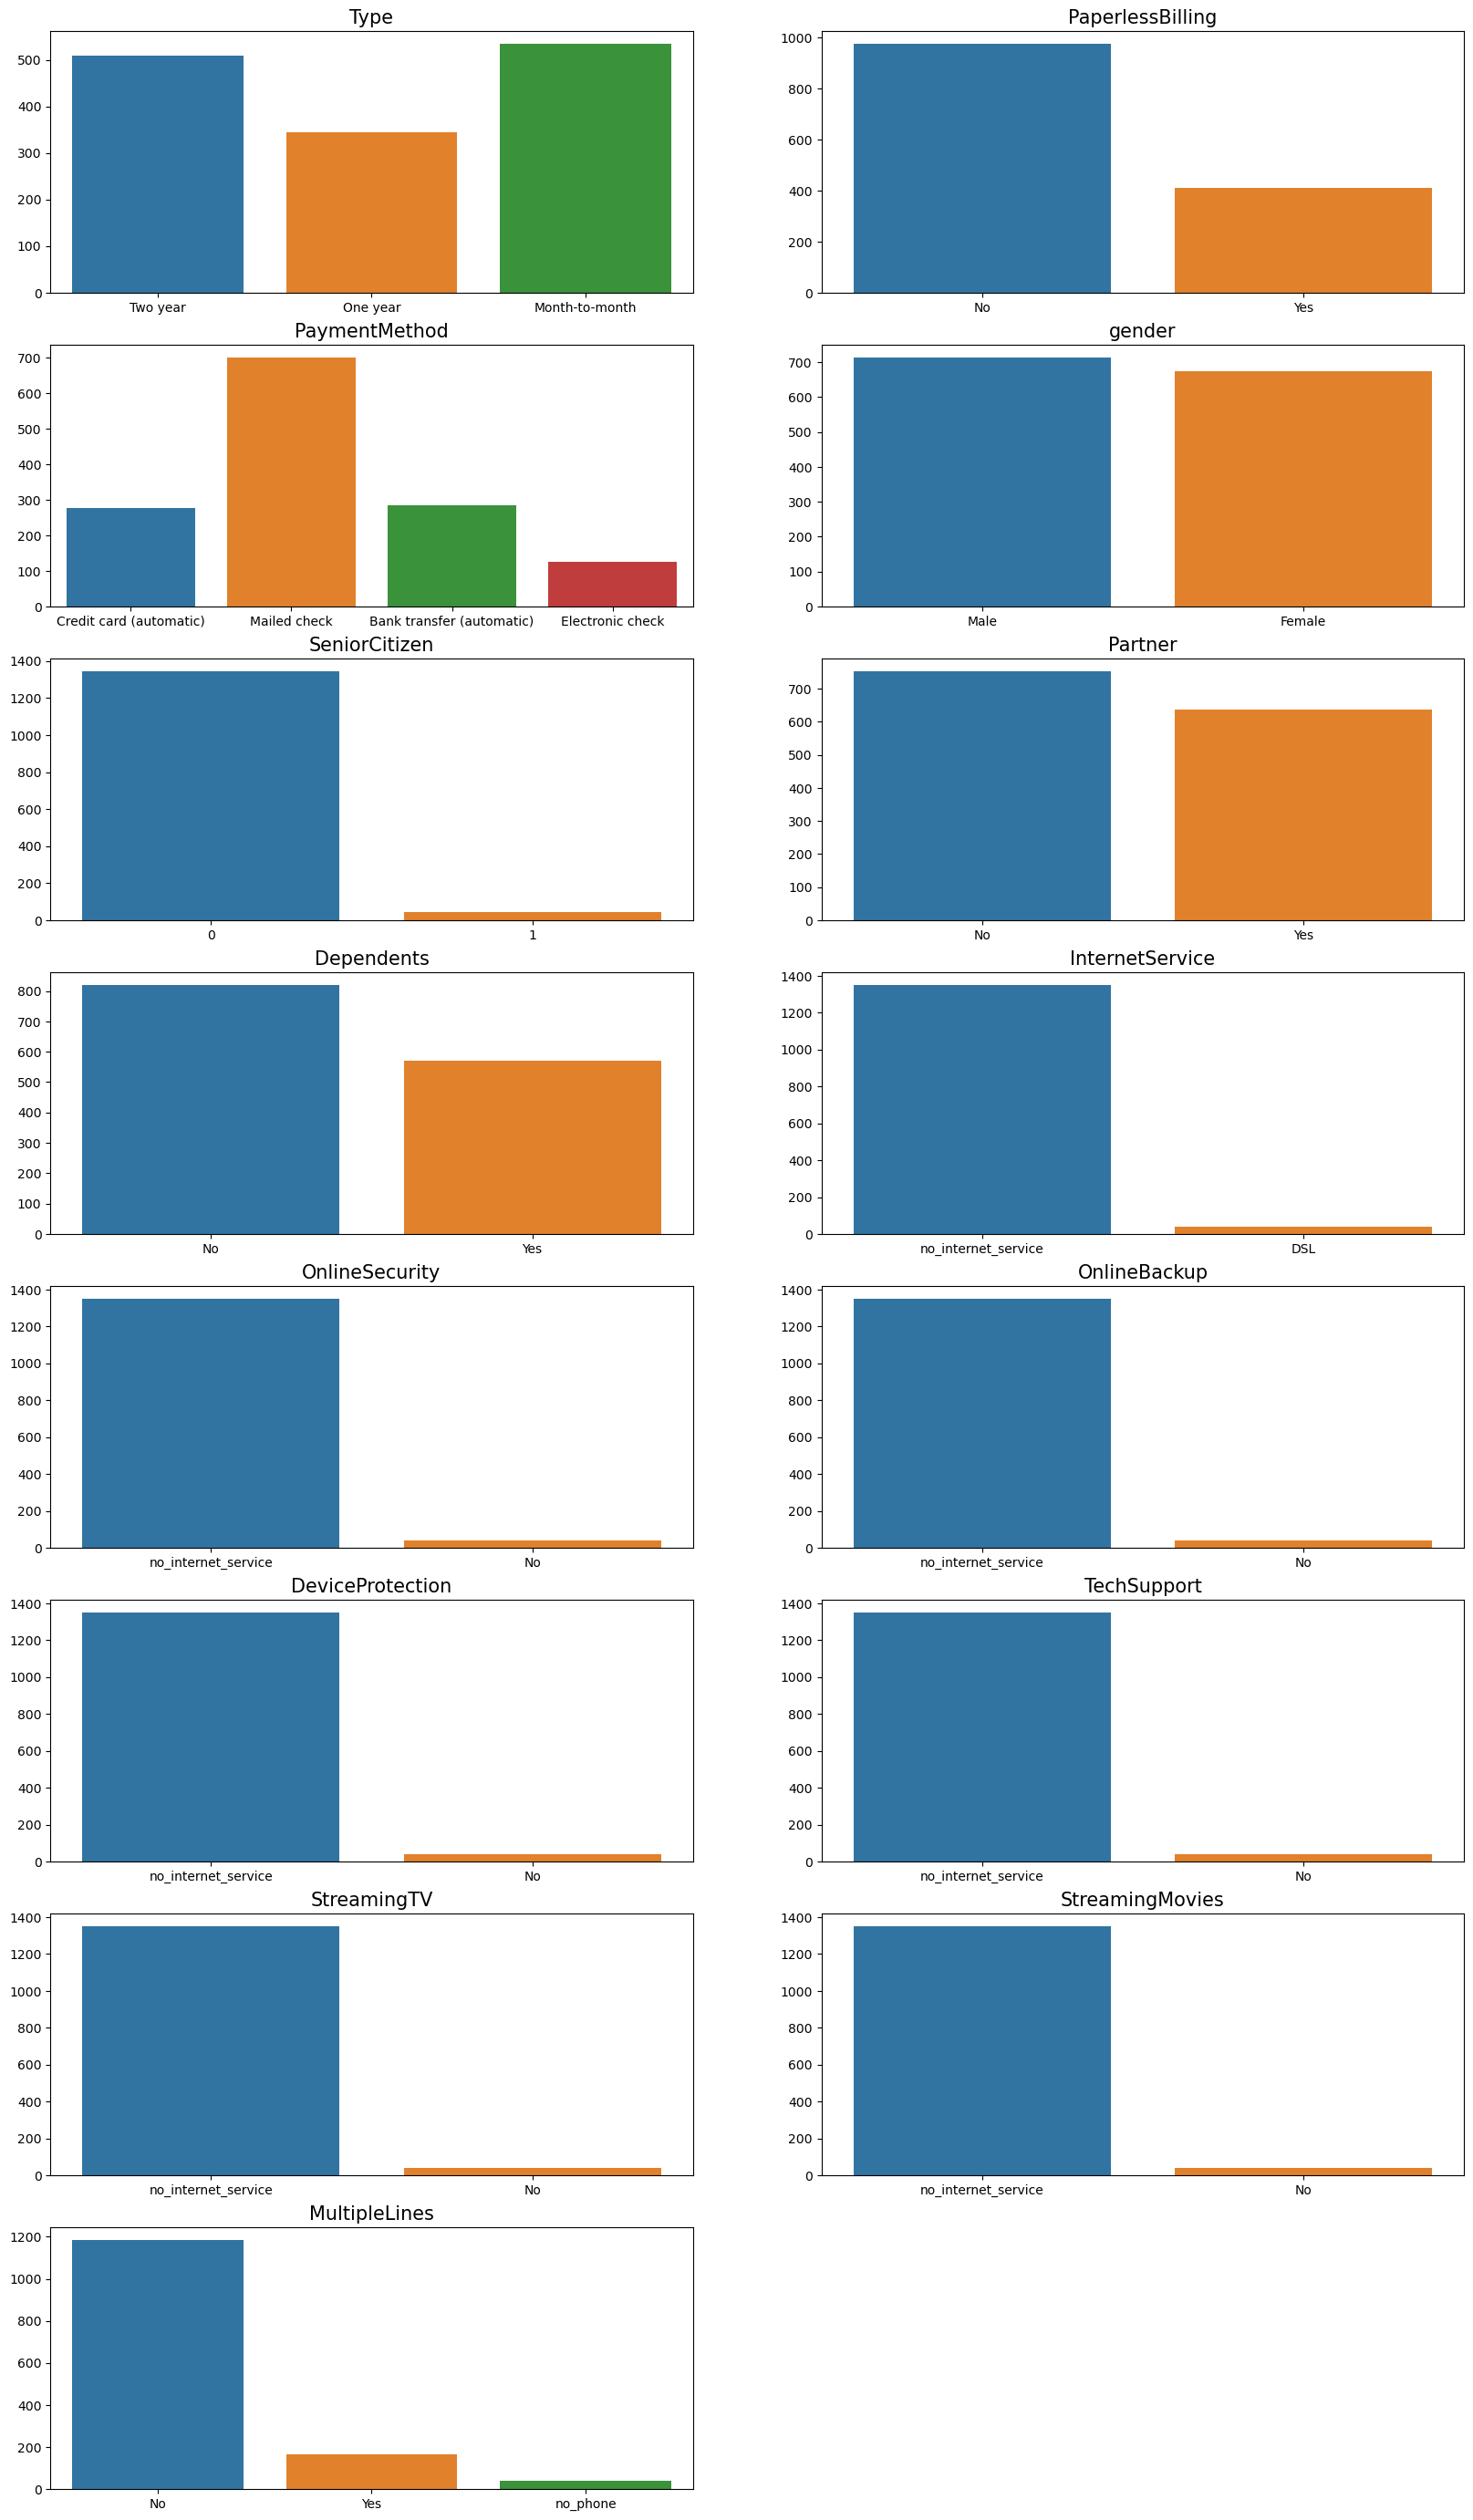

In [35]:
filtered_df = df_full[df_full['MonthlyCharges'] < 25]

num_plots = len(categorical_columns)
num_columns = 2
num_rows = int(np.ceil(len(categorical_columns) / num_columns))
fig, axs = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20,35))

for i, column in enumerate(categorical_columns):
    row = i // num_columns
    col = i % num_columns
    sns.countplot(data=filtered_df, x=column, ax=axs[row, col])
    axs[row, col].set_title(column, fontsize=15)
    axs[row, col].set_xlabel(None)
    axs[row, col].set_ylabel(None)
if num_plots < num_rows * num_columns:
    for j in range(num_plots, num_rows * num_columns):
        fig.delaxes(axs.flatten()[j])

plt.show()

####  Эти графики показывают, что эти клиенты используют только  телефон.

#### Проанализируем как категориальные признаки распределены относительно целевого признака target.

Type
Month-to-month    0.105032
One year          0.212492
Two year          0.224779
Name: target, dtype: float64

PaperlessBilling
No     0.132312
Yes    0.172860
Name: target, dtype: float64

PaymentMethod
Bank transfer (automatic)    0.205311
Credit card (automatic)      0.208279
Electronic check             0.147992
Mailed check                 0.072581
Name: target, dtype: float64

gender
Female    0.151376
Male      0.161181
Name: target, dtype: float64

SeniorCitizen
0    0.147263
1    0.203152
Name: target, dtype: float64

Partner
No     0.104916
Yes    0.211346
Name: target, dtype: float64

Dependents
No     0.148591
Yes    0.174408
Name: target, dtype: float64

InternetService
DSL                    0.142916
Fiber optic            0.192183
no_internet_service    0.104849
Name: target, dtype: float64

OnlineSecurity
No                     0.150372
Yes                    0.205547
no_internet_service    0.104849
Name: target, dtype: float64

OnlineBackup
No                     0.123381
Yes                    0.230548
no_internet_service    0.104849
Name: target, dtype: float64

DeviceProtection
No                     0.126333
Yes                    0.227085
no_internet_service    0.104849
Name: target, dtype: float64

TechSupport
No                     0.156349
Yes                    0.194716
no_internet_service    0.104849
Name: target, dtype: float64

StreamingTV
No                     0.127046
Yes                    0.215737
no_internet_service    0.104849
Name: target, dtype: float64

StreamingMovies
No                     0.120287
Yes                    0.221816
no_internet_service    0.104849
Name: target, dtype: float64

MultipleLines
No          0.094395
Yes         0.228206
no_phone    0.151026
Name: target, dtype: float64

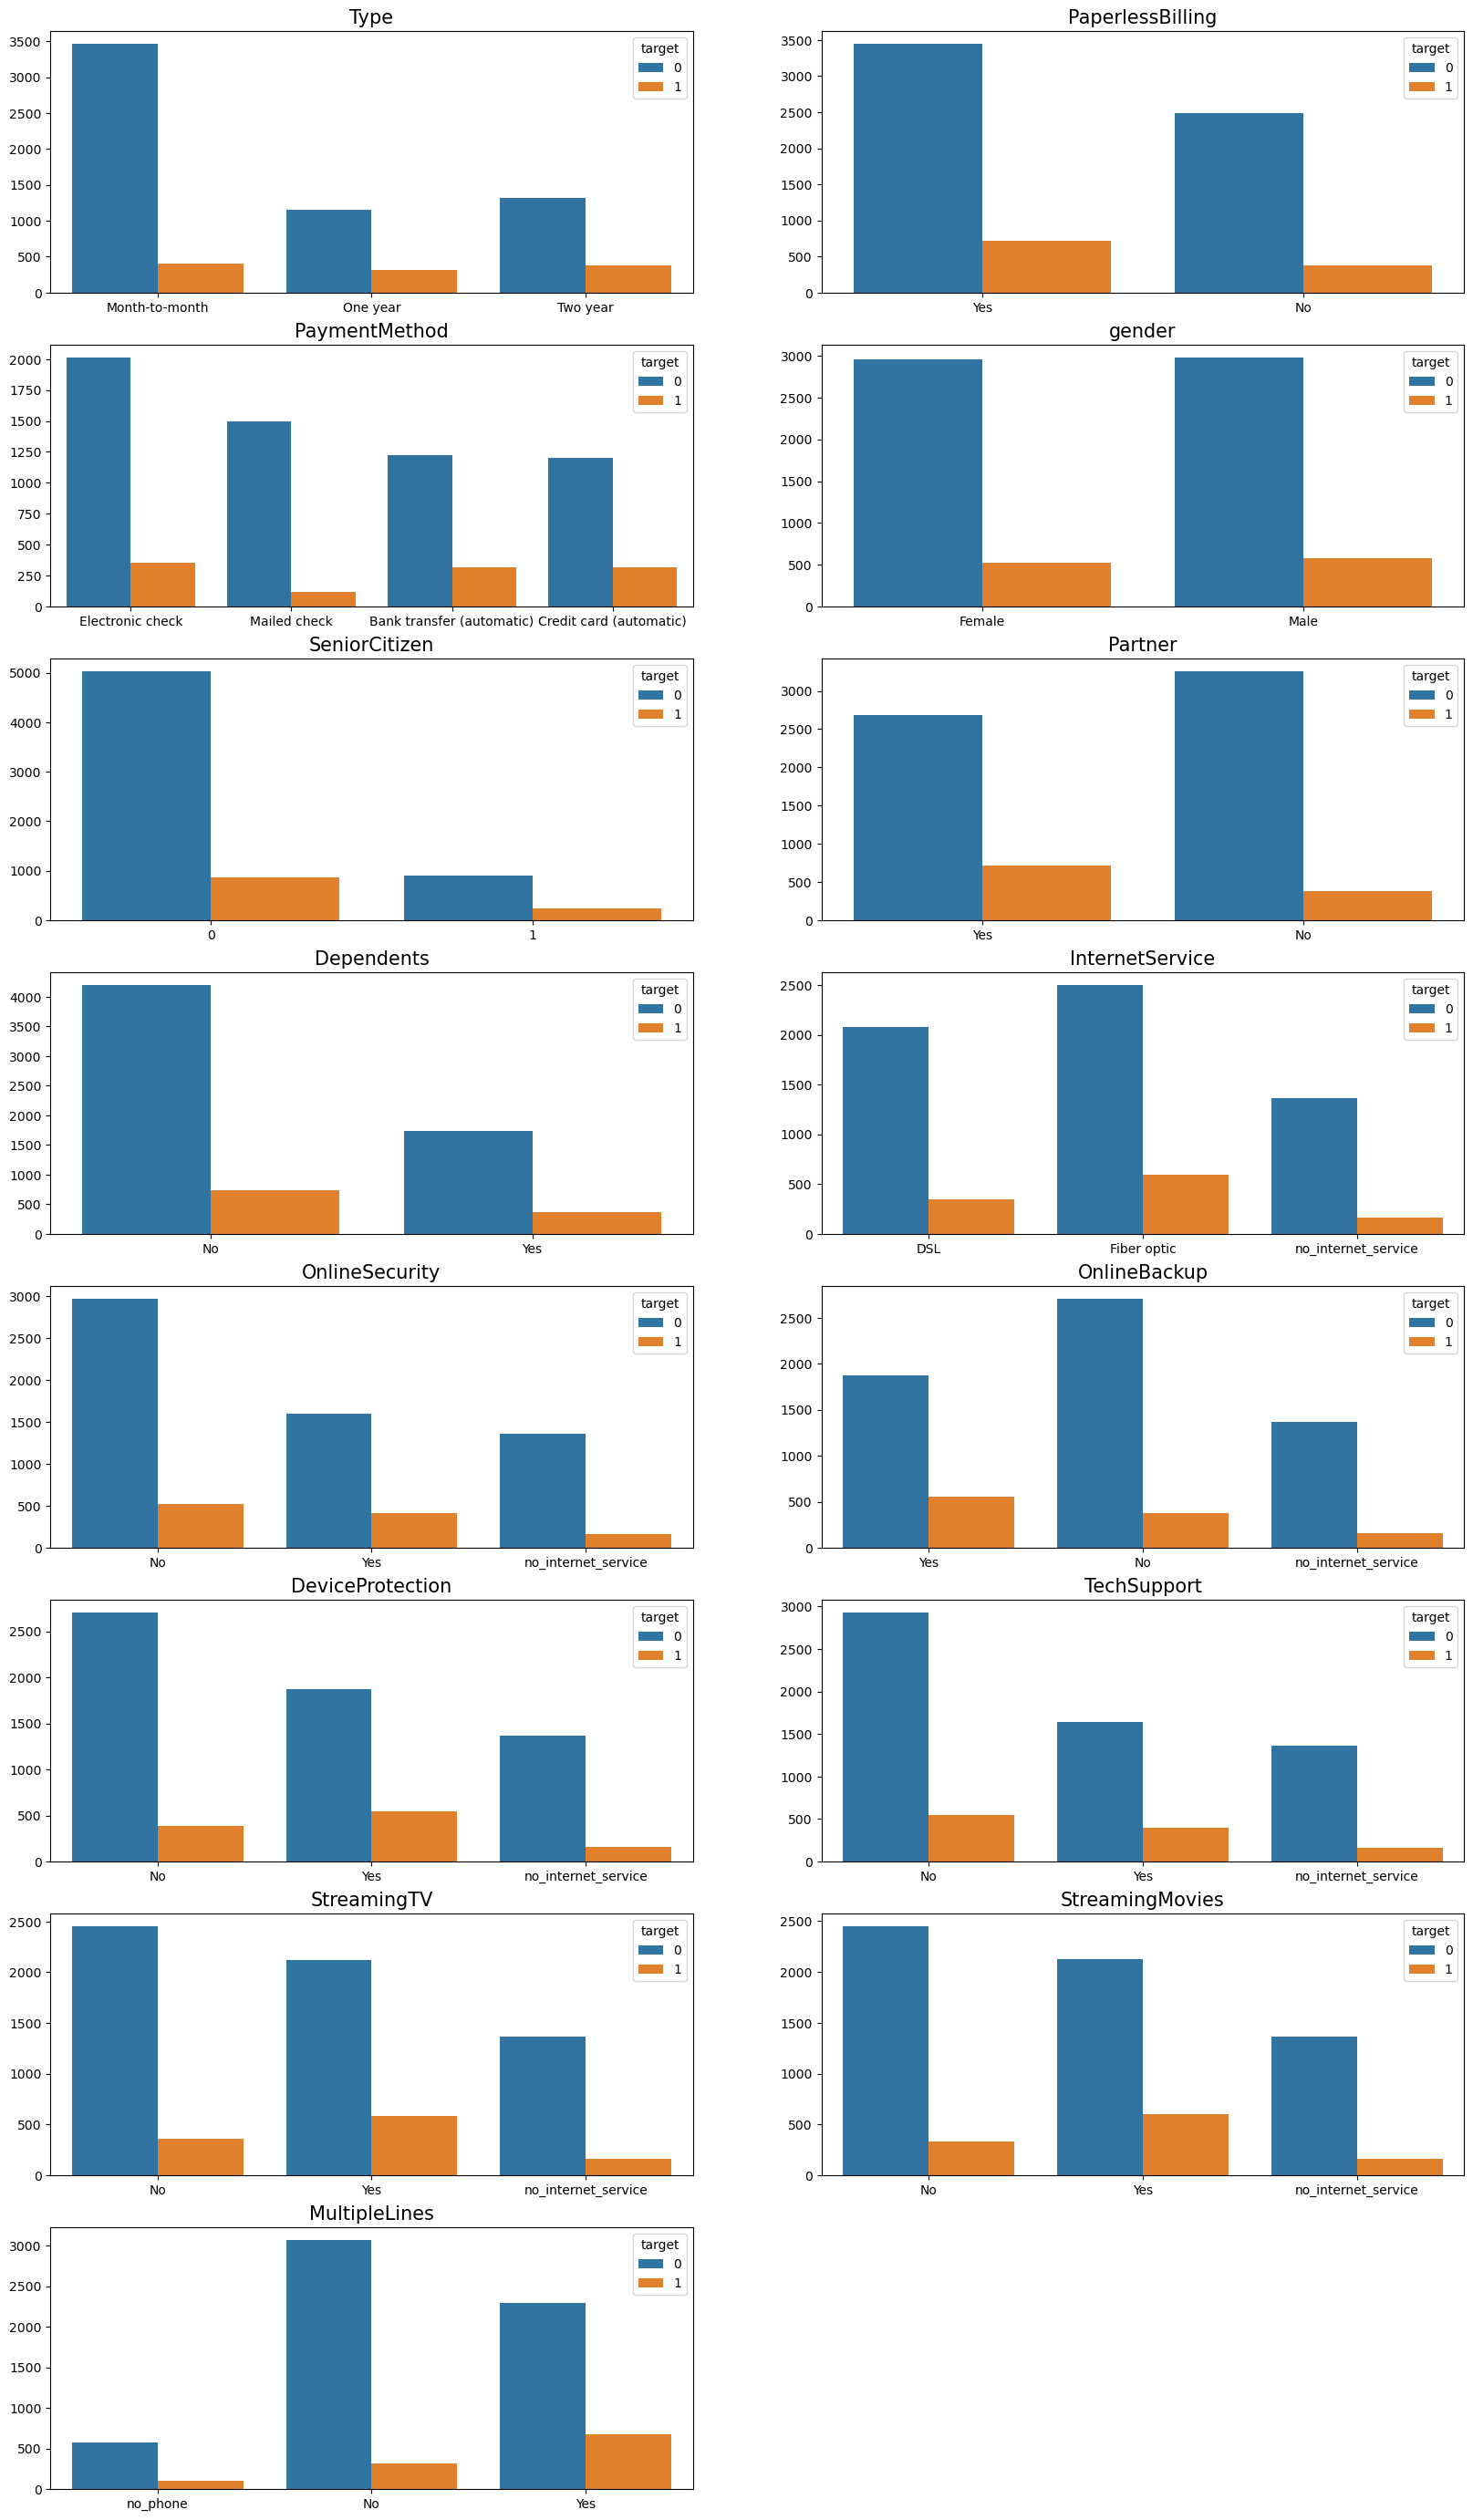

In [36]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20,35))
for i, column in enumerate(categorical_columns):
    row = i // num_columns
    col = i % num_columns
    df_grouped = df_full.groupby(column)['target'].mean()
    sns.countplot(data=df_full, x=column, hue='target', ax=axs[row, col])
    axs[row, col].set_title(column, fontsize=15)
    axs[row, col].set_xlabel(None)
    axs[row, col].set_ylabel(None)
    display(df_grouped)
if num_plots < num_rows * num_columns:
    for j in range(num_plots, num_rows * num_columns):
        fig.delaxes(axs.flatten()[j])

plt.show()

#### Графики показывают абсолютное число лояльных и ушедших клиентов в каждой категории. Однако, для получения более информативных данных, мы рассчитали долю ушедших клиентов в каждой категории. Обнаружено, что доля отказов среди клиентов, выбирающих помесячную оплату, в два раза ниже, чем среди клиентов, платящих за 1 или 2 года наперед. Также выяснилось, что доля отказов клиентов, имеющих партнера, в два раза выше, чем у клиентов без партнера. Отказы также происходят в два раза реже среди клиентов, не использующих интернет. Однако клиенты, использующие дополнительные интернет-услуги, имеют более высокую долю отказов по сравнению с клиентами, не использующими такие услуги. Пол и наличие детей почти не влияют на решение клиента об уходе. Отметим, доля отказов у пенсионеров выше, чем у молодых людей. Также обнаружено, что клиенты, использующие сервис MultipleLines, имеют более чем в два раза большую долю отказов, чем клиенты, не использующие этот сервис.

#### Проанализируем как цифровые признаки распределены относительно целевого признака target.

#### Построим графики для ушедших клиентов

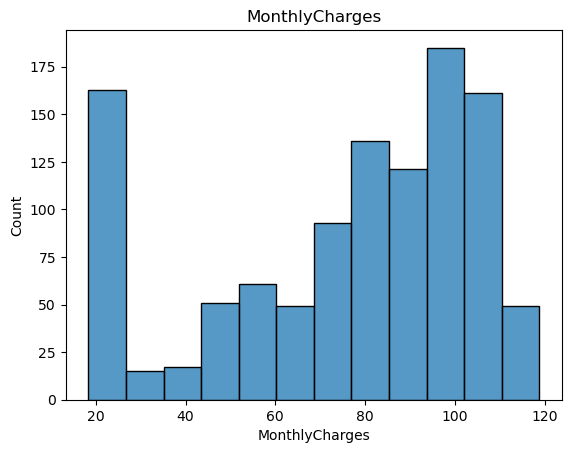

count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: MonthlyCharges, dtype: float64

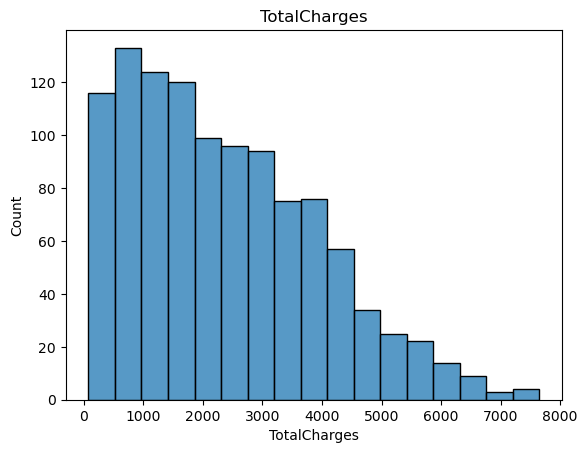

count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: TotalCharges, dtype: float64

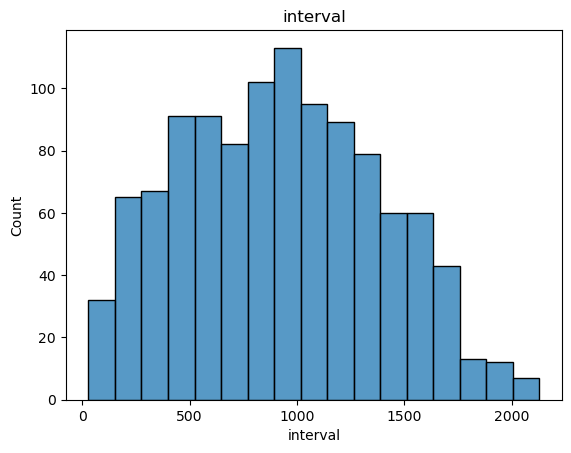

count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: interval, dtype: float64

In [37]:
numeric_columns = ['MonthlyCharges', 'TotalCharges','interval']
filtered_df = df_full[df_full['target'] == 1]
for column in numeric_columns:
        plt.figure()
        sns.histplot(filtered_df[column])
        plt.title(column)
        plt.show()
        display(filtered_df[column].describe())

#### Построим графики для оставшихся клиентов.

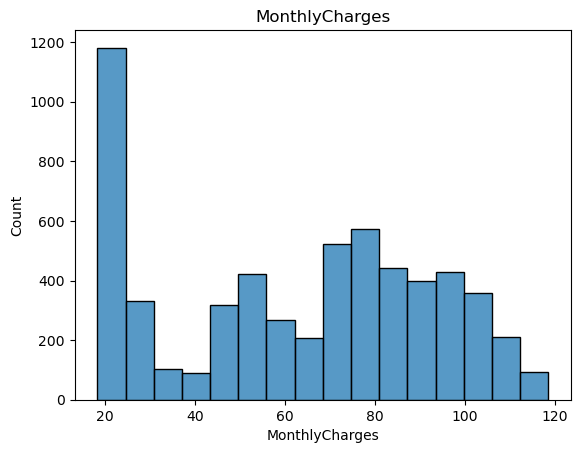

count    5942.000000
mean       62.763455
std        29.844462
min        18.250000
25%        30.062500
50%        69.200000
75%        87.237500
max       118.600000
Name: MonthlyCharges, dtype: float64

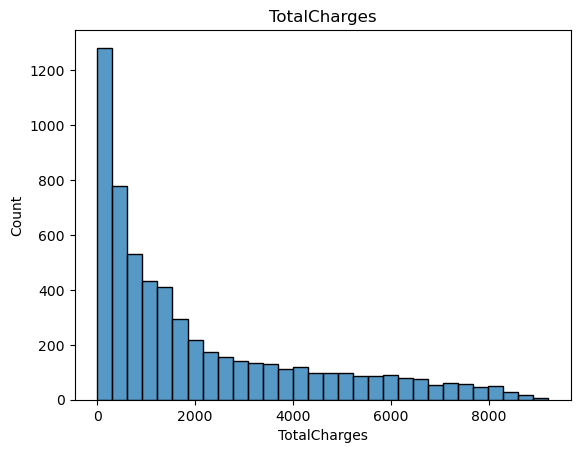

count    5942.000000
mean     2067.866420
std      2193.898483
min         0.000000
25%       374.352500
50%      1192.800000
75%      3173.837500
max      9221.380000
Name: TotalCharges, dtype: float64

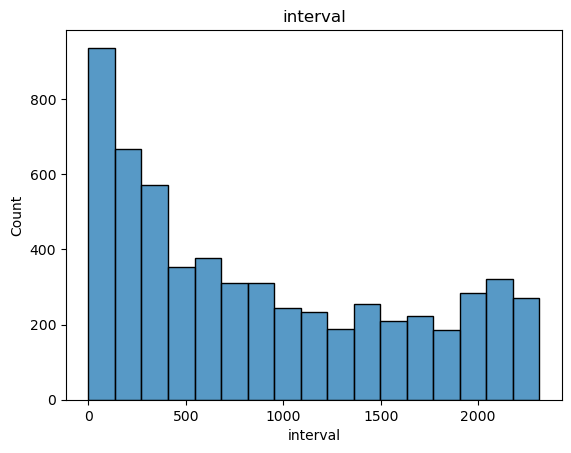

count    5942.000000
mean      893.681084
std       716.958551
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: interval, dtype: float64

In [38]:
filtered_df = df_full[df_full['target'] == 0]
for column in numeric_columns:
        plt.figure()
        sns.histplot(filtered_df[column])
        plt.title(column)
        plt.show()
        display(filtered_df[column].describe())

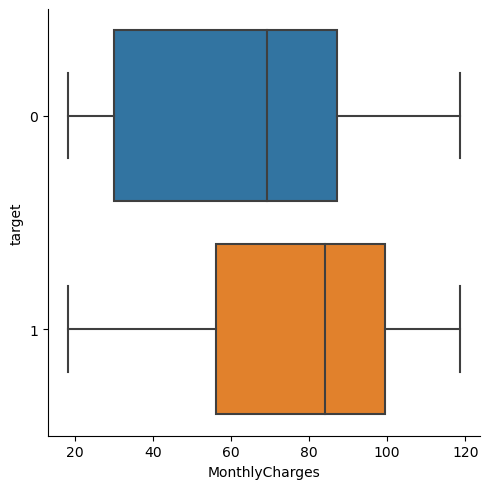

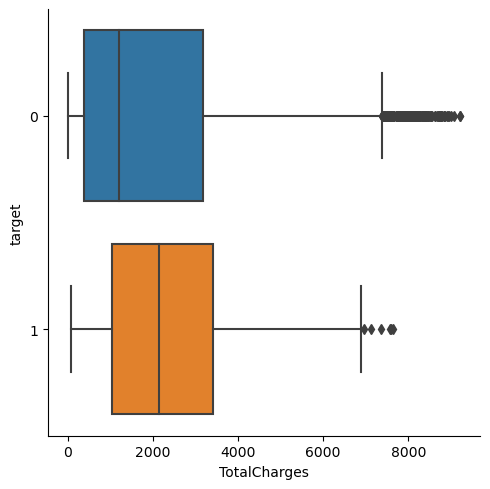

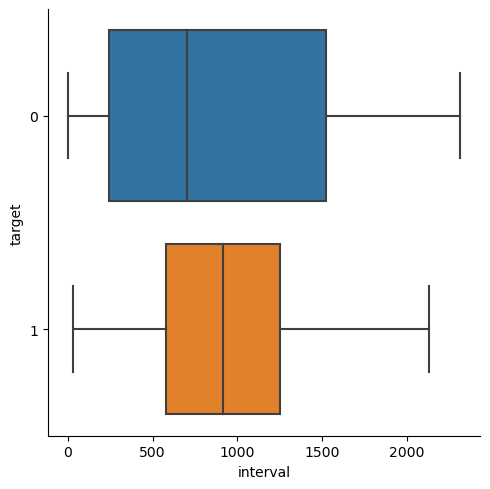

In [39]:
for column in  numeric_columns:
    sns.catplot(x=column, y='target',kind="box", data = df_full, orient='h')
    plt.show()

#### Текущие клиенты платят немного меньше в месяц по сравнению с теми, кто отказался.

#### Проверим корреляцию между количественными признаками

In [40]:
df_full[numeric_columns].corr()

,MonthlyCharges,TotalCharges,interval
MonthlyCharges,1.000000,0.630440,0.220054
TotalCharges,0.630440,1.000000,0.821746
interval,0.220054,0.821746,1.000000


####  Данные содержат проблему мультиколлинеарности, так как есть высокая корреляция (0,82) между полями TotalCharges и interval. Удалим поле TotalCharges из данных.

#### Воспользуемся Phik для анализа корреляции между признаками.

In [42]:
df = df_full.set_index('customerID')
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'interval']


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,interval,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
BeginDate,1.00,0.55,0.77,0.08,0.46,0.42,0.77,0.45,0.98,0.01,...,0.47,0.21,0.19,0.46,0.50,0.50,0.46,0.42,0.43,0.47
EndDate,0.55,1.00,0.29,0.06,0.17,0.17,0.22,1.00,0.40,0.02,...,0.18,0.06,0.12,0.17,0.24,0.23,0.15,0.19,0.20,0.25
Type,0.77,0.29,1.00,0.11,0.28,0.39,0.47,0.09,0.63,0.00,...,0.18,0.15,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24
PaperlessBilling,0.08,0.06,0.11,1.00,0.37,0.47,0.20,0.08,0.03,0.00,...,0.01,0.17,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10
PaymentMethod,0.46,0.17,0.28,0.37,1.00,0.40,0.34,0.21,0.35,0.00,...,0.24,0.22,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.17
MonthlyCharges,0.42,0.17,0.39,0.47,0.40,1.00,0.71,0.23,0.39,0.01,...,0.20,0.18,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71
TotalCharges,0.77,0.22,0.47,0.20,0.34,0.71,1.00,0.30,0.85,0.00,...,0.38,0.08,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47
target,0.45,1.00,0.09,0.08,0.21,0.23,0.30,1.00,0.37,0.01,...,0.23,0.05,0.06,0.06,0.09,0.09,0.05,0.08,0.09,0.11
interval,0.98,0.40,0.63,0.03,0.35,0.39,0.85,0.37,1.00,0.00,...,0.45,0.20,0.06,0.35,0.37,0.37,0.35,0.31,0.31,0.35
gender,0.01,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


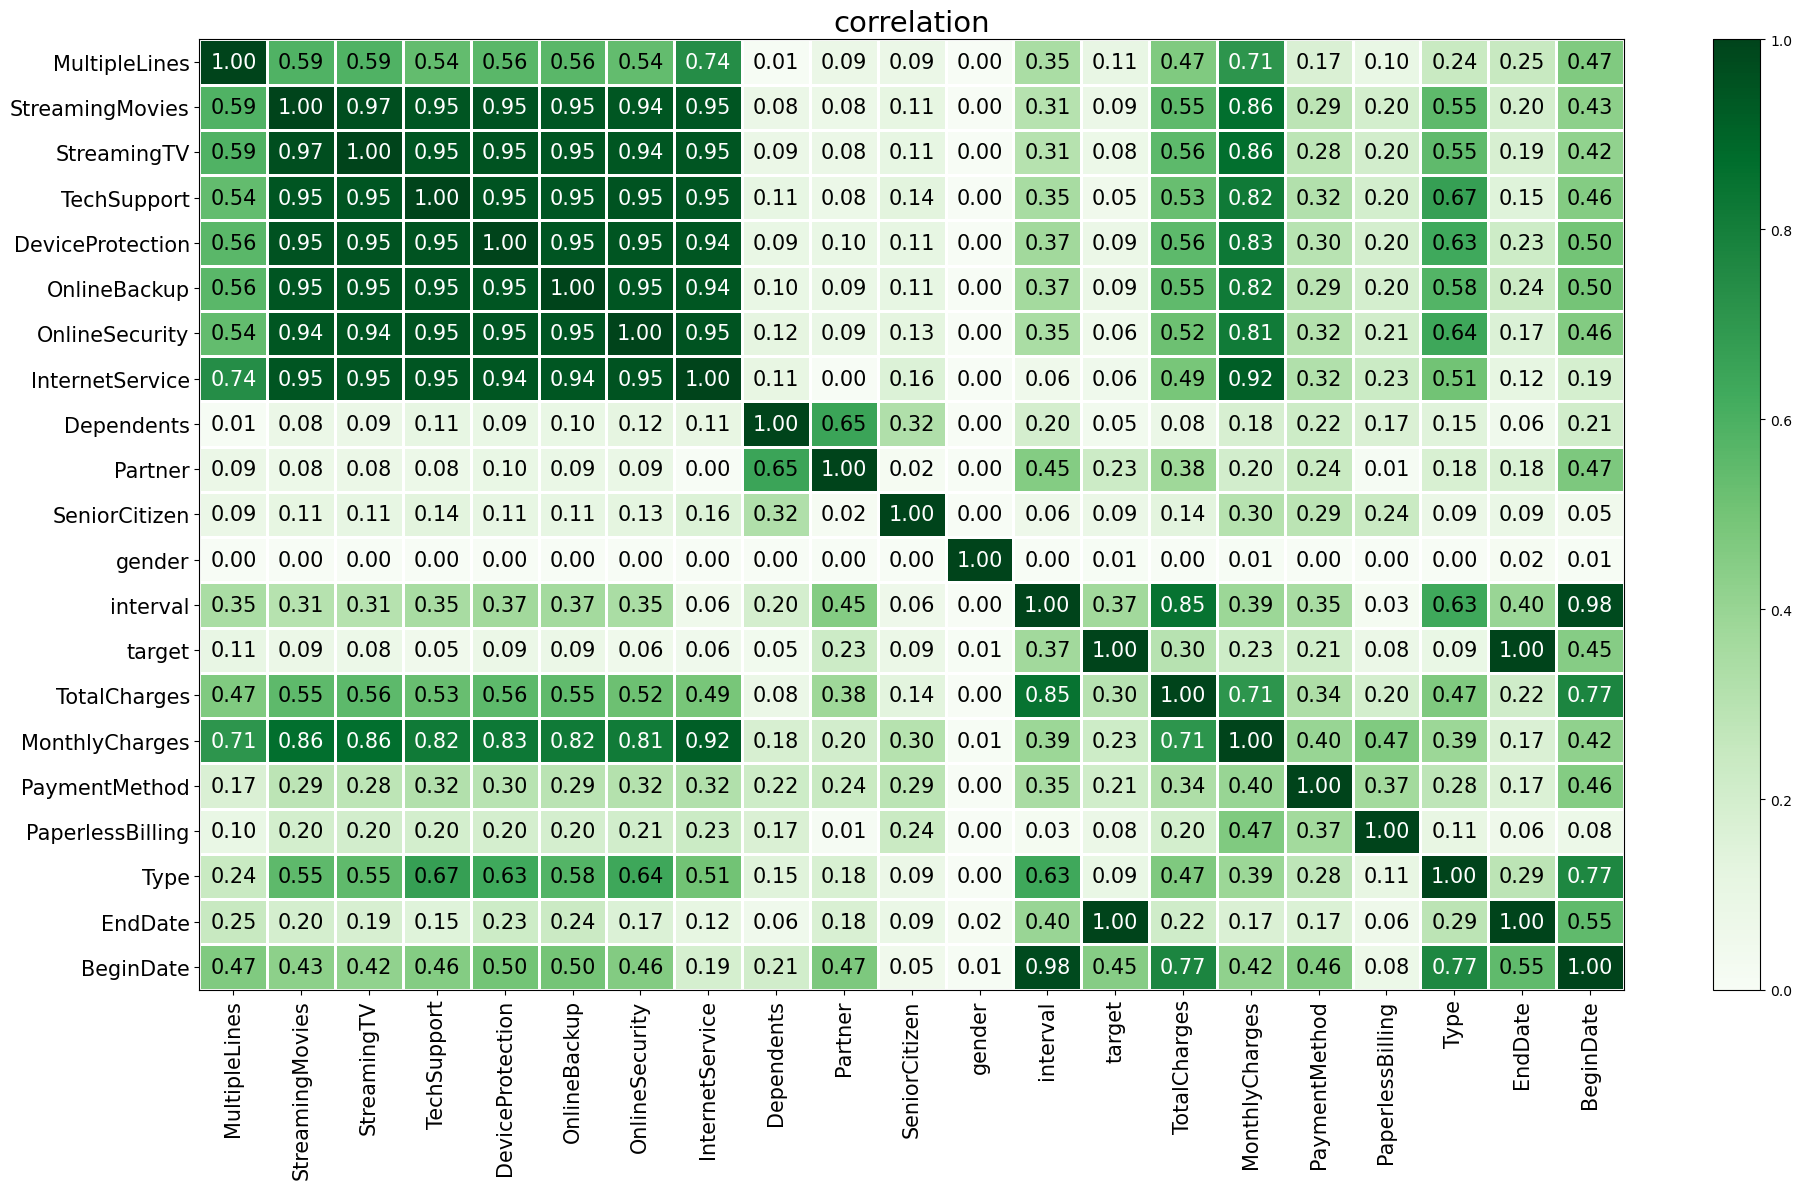

In [43]:
plot_correlation_matrix(phik_overview.values,
                       x_labels = phik_overview.columns,
                       y_labels = phik_overview.index,
                       vmin = 0,
                       vmax = 1,
                       color_map= "Greens",
                       fontsize_factor = 1.5,
                       figsize = (20, 12))
plt.show();

#### Столбец MonthlyCharges сильно коррелирует со столбцами InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies. . Кроме того, наблюдается сильная корреляция между столбцом Interval и столбцом BeginDate.   Сильная корреляция между столбцами дополнительных интернет услуг.  Заметим, что гендерный признак имеет практически нулевую корреляцию с целевым признаком.

### Подготовка данных для моделей

Удалим ненужные для обучения столбцы

In [44]:
df_full.drop(['customerID', 'BeginDate', 'EndDate'], axis=1, inplace=True)
df_full.drop(['TotalCharges'], axis=1, inplace=True)

In [45]:
display (df_full.sample(5))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,target,interval,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4306,Month-to-month,Yes,Credit card (automatic),110.10,0,1218,Male,0,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes
2633,One year,Yes,Bank transfer (automatic),100.15,1,1826,Female,0,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,No,Yes
6410,One year,No,Bank transfer (automatic),83.00,0,1918,Female,1,No,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes
6342,Month-to-month,Yes,Electronic check,104.10,0,1432,Male,0,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
6375,Month-to-month,Yes,Credit card (automatic),74.30,0,92,Female,0,No,No,Fiber optic,No,Yes,No,No,No,No,No


#### Выделим признаки  и целевую переменную target.

In [46]:
features = df_full.drop(['target'], axis=1)
target = df_full['target']


#### Разделим данные на обучающую и тестовую выборки.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=df_full['target']
)
print (X_train.shape)
print (y_test.shape)

(5282, 17)
(1761,)


In [48]:
print (y_train.shape)
print (X_test.shape)

(5282,)
(1761, 17)


In [49]:
ohe_features= X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [50]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['MonthlyCharges', 'interval']


#### Создаем объект make_column_transformer

In [51]:
ct = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features),
    remainder='passthrough',
    verbose_feature_names_out=False
)

### Обучение моделей

#### RandomForestClassifier

In [52]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [53]:
model_rf = RandomForestClassifier(random_state = RANDOM_STATE)
pipline_rf = make_pipeline(ct, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': range(50, 251, 50),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}
gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train)

gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.8191669902535598
best_params: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 8}


#### LogisticRegression

In [54]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()
model_lr = LogisticRegression(random_state = RANDOM_STATE)
pipeline_lr = make_pipeline(ct, model_lr)

param_grid_lr = [{'logisticregression__solver':['newton-cg', 'liblinear'],
                'logisticregression__C':[0.1, 1, 10]
                }]

gs_lr = RandomizedSearchCV(
    pipeline_lr,
    param_grid_lr,
    scoring='roc_auc',
    verbose = 3,
    n_jobs=-1,
    random_state=RANDOM_STATE)
gs_lr.fit(X_train_lr, y_train)

gs_lr_best_score = gs_lr.best_score_
gs_lr_best_params = gs_lr.best_params_
print(f'best_score: {gs_lr_best_score}')
print(f'best_params: {gs_lr_best_params}')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
best_score: 0.7519782364462239
best_params: {'logisticregression__solver': 'newton-cg', 'logisticregression__C': 10}


#### LGBMClassifier

In [55]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

model_lgbm = LGBMClassifier(random_state = RANDOM_STATE)
pipeline_lgbm = make_pipeline(ct, model_lgbm)

param_grid_lgbm = [{'lgbmclassifier__n_estimators': [100, 150],
                    'lgbmclassifier__max_depth': [10, 15]
                    }]

gs_lgbm = RandomizedSearchCV (pipeline_lgbm, param_grid_lgbm, scoring='roc_auc', verbose = 3, random_state = RANDOM_STATE)
gs_lgbm.fit(X_train_lgbm, y_train)

gs_lgbm_best_score = gs_lgbm.best_score_
gs_lgbm_best_params = gs_lgbm.best_params_
print(f'best_score: {gs_lgbm_best_score}')
print(f'best_params: {gs_lgbm_best_params}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimators=100;, score=0.843 total time=   0.1s
[CV 2/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimators=100;, score=0.901 total time=   0.0s
[CV 3/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimators=100;, score=0.875 total time=   0.0s
[CV 4/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimators=100;, score=0.884 total time=   0.0s
[CV 5/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimators=100;, score=0.880 total time=   0.0s
[CV 1/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimators=150;, score=0.853 total time=   0.0s
[CV 2/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimators=150;, score=0.914 total time=   0.0s
[CV 3/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimators=150;, score=0.883 total time=   0.0s
[CV 4/5] END lgbmclassifier__max_depth=10, lgbmclassifier__n_estimat

### Тестирование лучшей модели.

#### Выберем лучшую модель по результатам кросс-валидации.

In [56]:
table = pd.DataFrame([gs_rf.best_score_, gs_lr.best_score_, gs_lgbm.best_score_],
             columns=['ROC_AUC'],
             index=['RF','LR','LGBM' ])
display(table)

,ROC_AUC
RF,0.819167
LR,0.751978
LGBM,0.886816


#### LGBMClassifier показал лучшее значение метрики ROC-AUC - 0.88

#### Посчитаем значение метрики  ROC-AUC  лучшей модели на тестовой выборке.

In [57]:
pred_prob = gs_lgbm.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, pred_prob)
print("Значение метрики ROC-AUC для тестовой выборки:", roc_auc)

Значение метрики ROC-AUC для тестовой выборки: 0.9054104979811575


#### Создадим функцию для построения ROC-кривой.

In [58]:
def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_probs)

    # Вычислить значение площади под ROC-кривой (AUC)
    roc_auc = metrics.auc(fpr, tpr)

    # Построить ROC-кривую
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.show()

#### Построим  ROC-кривую для лучшей модели.

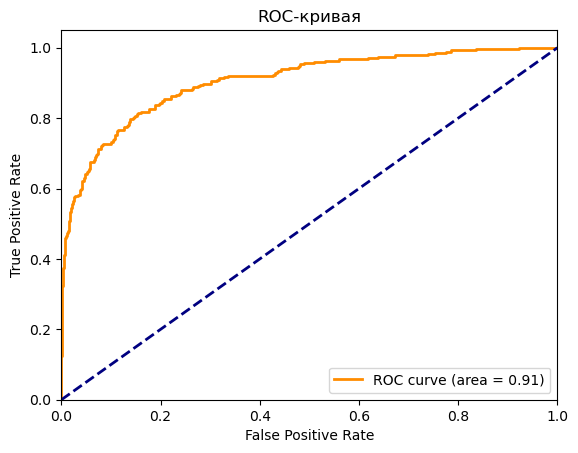

In [59]:
predicted_probalities = gs_lgbm.best_estimator_.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, predicted_probalities)

#### Вычиcлим важность факторов.

In [60]:
X_train = pd.DataFrame(ct.fit_transform(X_test), columns = ct.get_feature_names_out() )

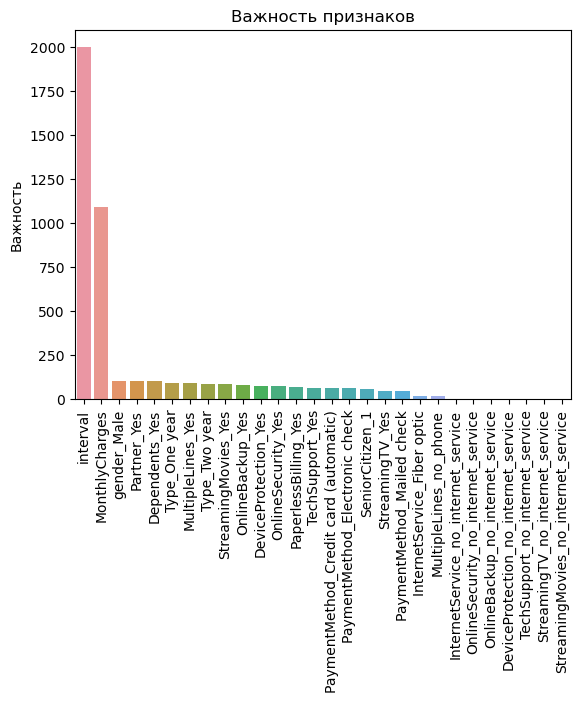

,Features,Importance
1,interval,2000
0,MonthlyCharges,1094
8,gender_Male,104
10,Partner_Yes,104
11,Dependents_Yes,103
2,Type_One year,96
26,MultipleLines_Yes,93
3,Type_Two year,88
24,StreamingMovies_Yes,87
16,OnlineBackup_Yes,83


In [61]:
importances = pd.DataFrame({
          'Features': X_train.columns,
          'Importance':gs_lgbm.best_estimator_._final_estimator.feature_importances_
      })
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure()
sns.barplot(x=importances['Features'], y=importances['Importance'])
plt.title('Важность признаков')
plt.xticks(rotation='vertical')
plt.xlabel(None)
plt.ylabel('Важность')
plt.show()
display(importances)

In [62]:
table=pd.DataFrame(columns=['roc_auc',
                          'accuracy',
                          'f1_score',
                          'precision',
                          'recall',
                          'num features'
                         ],
                 data=[[roc_auc_score(y_test, gs_lgbm.best_estimator_.predict_proba(X_test)[:, 1]),
                        accuracy_score(y_test, gs_lgbm.best_estimator_.predict(X_test)),
                        f1_score(y_test,gs_lgbm.best_estimator_.predict(X_test)),
                        precision_score(y_test,gs_lgbm.best_estimator_.predict(X_test)),
                        recall_score(y_test,gs_lgbm.best_estimator_.predict(X_test)),
                        X_train.shape[1]
                        ]]
                )
display(table)

,roc_auc,accuracy,f1_score,precision,recall,num features
0,0.90541,0.911982,0.654788,0.844828,0.534545,28


### Вывод

#### В данной исследовательской работе осуществлялся прогноз отказа клиента от услуг оператора связи. Вначале данные были проанализированы и сделаны предварительные выводы. Затем проводилась первичная обработка данных, включающая изменение типов данных некоторых столбцов и обработка пропусков в данных. С целью предсказания отказа клиентов, были добавлены два новых столбца: целевой признак "target" (отказ клиента) и "interval" (продолжительность пользования услугами). Далее проводился исследовательский анализ данных, анализировались количественные и категориальные признаки с целью выявления возможной связи с целевым признаком.Затем проводилась подготовка данных для обучения моделей: удаление ненужных столбцов,  кодирование категорианных данных используя OHE (One-Hot Encoding), масштабирование количественных признаков, разделение датафрейма на обучающую и тестовую выборки. Далее на данных было проведено обучение трех моделей: LogisticRegression, RandomForestClassifier и LGBMClassifier. Лучший результат показала модель LGBMClassifier с метрикой ROC-AUC 0.90, что превышает требуемое значение. Основными факторами, влияющими на отказ, являются длительность пользования услугами и ежемесячная плата клиента.

### Отчет

#### Введение:

Целью данного проекта было проанализировать данные оператора связи «Ниединогоразрыва.ком», построить модель предсказания, которая будет определять, останется ли пользователь клиентом компании или уйдет и  достичь значение метрики ROC-AUC  модели не ниже 0.85.

#### Получение данных:

Исходные данные состоят из 4 файлов, полученных из разных источников, содержащую информацию о договораx с клиентом, персональные данные клиента, информация об интернет-услугах и информация об услугах телефонии исппользуемых клиентом.

#### Предобработка данных:

Перед началом анализа данных были выполнены следующие этапы предобработки:

* Загрзука и знакомство с данными. Исходные таблицы до соединения не имеют пропусков и дупликатов и имеют общий стобец customerID, по которому можно объединить все таблицы.

* Преобразование типов данных. Тип данных колонки TotalCharges изменен на числовой тип, тип данных  SeniorCitizen на ктегориальный тип, тип данных столбцов BeginDate и EndDate на тип данных date. Так как  представленная информация о договорах актуальна на 01.02.2020, то для клиентов продолжающих пользоваться услугами компании (значение "No" в столбце EndDate)  в качестве даты окончания договора  использовали дату 01.02.2020.

* Был добавлен новый столбец target содержащий значение целевого признака. Признак означает отказался клиент от услуг или нет.

* Был добавлен новый столбец период пользования услугами компании - interval.

* Было проиизведено объединеним таблиц по общему столбцу customerID.

* Заполнение  пропусков. Пропуски в  итоговой таблице после объединения указывают, что клиент не использовал определенную услугу. Поэтому для телефонов мы заполнили пропущенные значения меткой 'no_phone', а для интернета - 'no_internet_service'. В колонке TotalCharges пропуски были у  новых клиентов, подписавших договор 2020-02-01, т.е. на момент выгрузки данных у них дествительно отсутствовал платеж. Заполнили пропущенные значения нулями.

#### Исследовательский анализ данных:

На этом этапе был проведен анализ основных характеристик данных, исследованы закономерности и взаимосвязи между переменными. Выявлены следующие ключевые особенности:

 * компания активно развивалась
 * 15,6% клиентов решили прекратить пользоваться услугами компании
 * в среднем, длительность использования услуг для клиентов, которые расторгли договор, составляет 1000 дней
 * наблюдается тенденция к увеличению числа заключенных договоров начиная с 2018 года
 * со временем количество расторгнутых договоров растет
 * большинство клиентов предпочитает оплачивать счета ежемесячно через электронный чек, получая счета в электронном виде
 * оптоволокно является самым распространенным способом подключения
 * гендерный состав клиентов компании практически равномерно распределен
 * количество клиентов, не имеющих партнера, немного превышает количество клиентов, имеющих супруга или супругу
 * около 15% клиентов компании находятся в пенсионном возрасте
 * среди клиентов наблюдается значительно меньшее количество клиентов, у которых есть иждивенцы
 * около половины интернет-пользователей использует услуги OnlineBackup, StreamingTV и StreamingMovies
 * услуги OnlineSecurity, DeviceProtection, TechSupport менее популярны среди пользователей
 * MultipleLines используют менее половины клиентов

* доля отказов среди клиентов, выбирающих помесячную оплату, в два раза ниже, чем среди клиентов, платящих за 1 или 2 года наперед
* доля отказов клиентов, имеющих партнера, в два раза выше, чем у клиентов без партнера
* отказы также происходят в два раза реже среди клиентов, не использующих интернет
*  клиенты, использующие дополнительные интернет-услуги, имеют более высокую долю отказов по сравнению с клиентами, не использующими такие услуги
* пол и наличие детей почти не влияют на решение клиента об уходе
* доля отказов у пенсионеров выше, чем у молодых людей
* клиенты, использующие сервис MultipleLines, имеют более чем в два раза большую долю отказов, чем клиенты, не использующие этот сервис
* текущие клиенты платят немного меньше в месяц по сравнению с теми, кто отказался

Используя коэффициент корреляции Phik  изучены взаимосвязи между признаками.

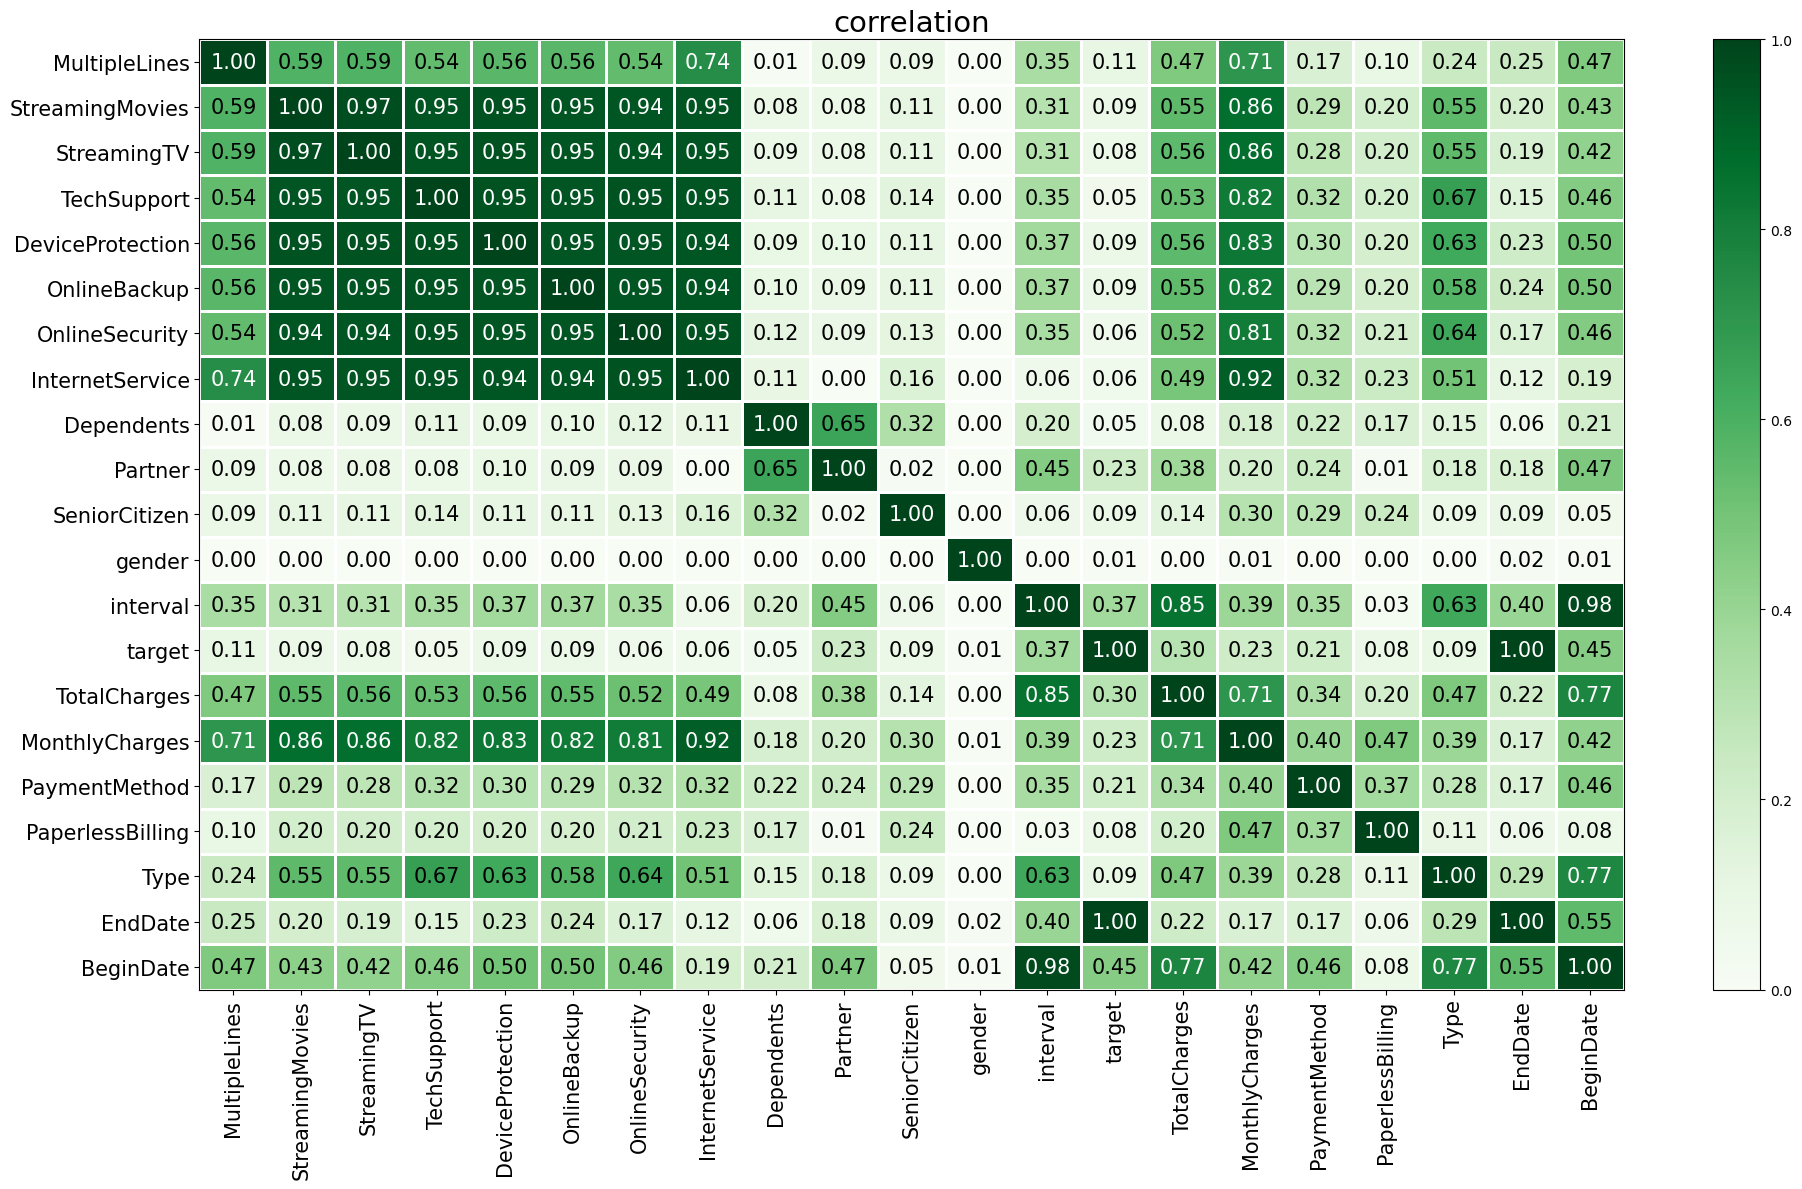

* столбец MonthlyCharges сильно коррелирует со столбцами InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies
* наблюдается сильная корреляция между столбцом Interval и столбцом BeginDate
* сильная корреляция между столбцами дополнительных интернет услуг
* гендерный признак имеет практически нулевую корреляцию с целевым признаком

Данные содержали проблему мультиколлинеарности, так как существовала  высокая корреляция  между полями TotalCharges и interval. Удалили поле TotalCharges из данных.

#### Подготовка данных для моделей:

* Были удаленны ненужные для обучения  столбцы customerID, BeginDate, EndDate.

* Выделенны  целевые  признаки и целевая переменная target

* Данные были разделенны  на обучающую и тестовую выборки в соотношение 3/1. Использован random_state = 30723  и cтратификация по целевому признаку target.

* Создан объект make_column_transformer для  кодирования категориальных признаков (использоваkся OneHotEncoder) и масштабирования числовых признаков( использовался StandardScaler)

#### Построение и обучение моделей:

* Были использованы различные алгоритмы машинного обучения, включая логистическую регрессию, случайный лес и градиентный бустинг (LGBM).

* Для подбора гиперпараметров использоваося  RandomizedSearchCV + pipeline. Кодирование и масштабирование признаков осуществялось с помощью объекта make_column_transformer.  Использовалась  метрика ROC-AUC.

Использованы для обучения следующие признаки:


* 'MonthlyCharges'
* 'interval'
* 'Type_One year'
* 'Type_Two year'
* 'PaperlessBilling_Yes'
* 'PaymentMethod_Credit card (automatic)'
* 'PaymentMethod_Electronic check'
* 'PaymentMethod_Mailed check'
* 'gender_Male'
* 'SeniorCitizen_1'
* 'Partner_Yes'
* 'Dependents_Yes'
* 'InternetService_Fiber optic'
* 'InternetService_no_internet_service'
* 'OnlineSecurity_Yes'
* 'OnlineSecurity_no_internet_service'
* 'OnlineBackup_Yes'
* 'OnlineBackup_no_internet_service'
* 'DeviceProtection_Yes'
* 'DeviceProtection_no_internet_service'
* 'TechSupport_Yes'
* 'TechSupport_no_internet_service'
* 'StreamingTV_Yes'
* 'StreamingTV_no_internet_service'
* 'StreamingMovies_Yes'
* 'StreamingMovies_no_internet_service'
* 'MultipleLines_Yes'
* 'MultipleLines_no_phone'
      

#### Тестирование лучшей модели:

* По итогам  кросс-валидации была выбранна лучшая модель. Лучшие результаты показала модель LGBMClassifier с гиперпамметрами  {'lgbmclassifier__n_estimators': 150, 'lgbmclassifier__max_depth': 10},   random_state = 30723.

* Построена  ROC-кривая для лучшей модели. Значение метрики ROC-AUC: 0.9054104979811575

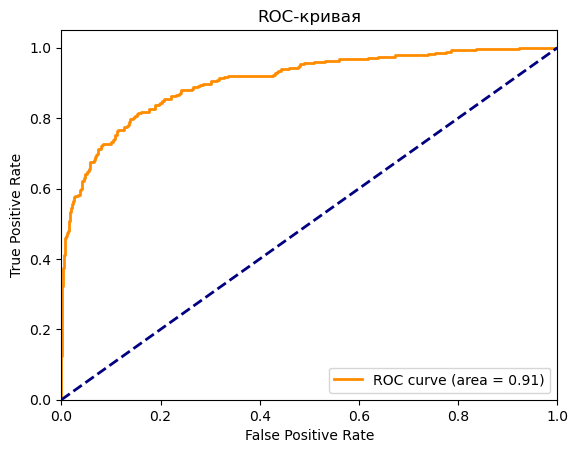

* Выделена важность факторов для лучшей модели. Основными факторами, влияющими на отказ клиента, являются длительность пользования услугами и ежемесячная плата клиента.

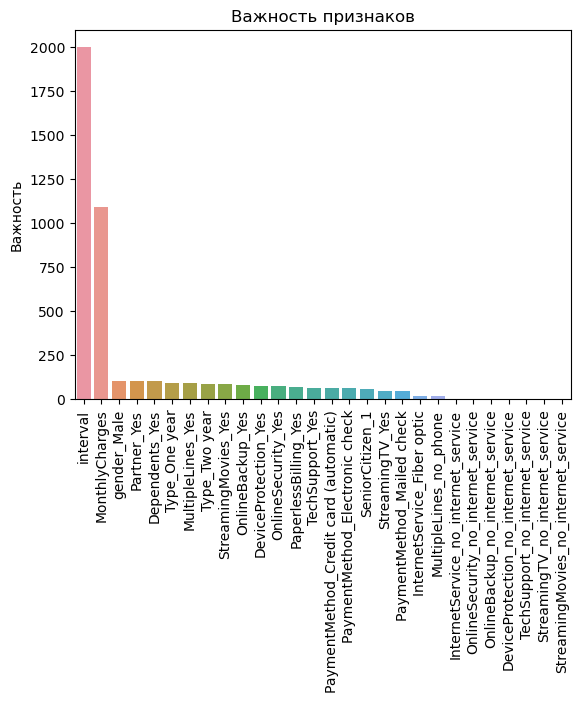

* Вычислены метрики итоговой модели на тестовой выборке:

* roc_auc   0.90541
* accuracy  0.911982
* f1_score  0.654788
* precision 0.844828
* recall    0.534545

* Таким образом были выполнены все пункты задуманного плана за исключением построения  ROC- кривой для каждой модели. Я отказался от выпонения данного пункта ,т.к.проверка только лучшей модели на тестовой выборке позволяет получить надежные результаты и эффективно использовать ресурсы. Достигнуто требуемое занчение метрики.